<a href="https://colab.research.google.com/github/abuabdurahman82/Enhancing-Workplace-Safety-A-Computer-Vision-System-for-Detecting-Helmet-and-Vest-Usage/blob/main/PPE_Detection_YOLOv8_GoogleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Workplace Safety: PPE Detection using YOLOv8

**Project Title:** Enhancing Workplace Safety: A Computer Vision System for Detecting Helmet and Vest Usage

**Team:** Team 9
- Faisal Abdul Gaffoor

**GitHub Repository:** [Enhancing-Workplace-Safety](https://github.com/abuabdurahman82/Enhancing-Workplace-Safety-A-Computer-Vision-System-for-Detecting-Helmet-and-Vest-Usage)

**Live Demo:** [Gradio Application](https://0c6f8a94fc0bf5f4b2.gradio.live)

---

## Project Overview

This project develops and evaluates a computer vision system for automatically detecting Personal Protective Equipment on construction sites. Using the YOLOv8 object detection model, the system is trained to identify people and classify them based on whether they are wearing a safety helmet.

### Project Objectives

The primary objectives of this project are to create a reliable, real-time tool that can enhance workplace safety by automating compliance monitoring and reducing the risk of injuries from inadequate PPE usage. The model is evaluated using standard metrics including accuracy, precision, and recall.

### Dataset Information

The dataset used in this project is sourced from Roboflow's Hard Hat Workers Dataset, which is publicly available at [https://public.roboflow.com/object-detection/hard-hat-workers](https://public.roboflow.com/object-detection/hard-hat-workers). The dataset contains a total of 7,523 images divided into training, validation, and test sets.

The training set consists of 5,265 images, the validation set contains 1,505 images, and the test set includes 753 images. All images have been pre-processed to a consistent dimension of 640x640 pixels, which is optimal for YOLOv8 model training.

The dataset includes three classes: helmet, head, and person. The annotations are provided in YOLOv8 format with normalized bounding box coordinates.

---

## Step 1: Environment Setup and Installation

In this first step, we will set up the Google Colab environment and install all required libraries for the project.

In [ ]:
# Check if GPU is available for training
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("WARNING: GPU not available. Training will be significantly slower on CPU.")
    print("To enable GPU: Go to Runtime > Change runtime type > Hardware accelerator > GPU")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Device: NVIDIA L4
Number of GPUs: 1


In [ ]:
# Install required libraries for the project
!pip install ultralytics roboflow opencv-python-headless matplotlib seaborn pandas numpy pillow
!pip install gradio

print("All dependencies have been installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
All dependencies have been installed successfully.


In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from pathlib import Path
import yaml
import shutil
from collections import Counter
import json

# Import Ultralytics YOLOv8 and Roboflow
from ultralytics import YOLO
from roboflow import Roboflow

# Set plotting style for better visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries have been imported successfully.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
All libraries have been imported successfully.


## Step 2: Mount Google Drive and Load Dataset

In this step, we will mount Google Drive and load the Hard Hat Workers dataset that you have manually uploaded.

### Prerequisites:

Before running this step, make sure you have:
1. Downloaded the Hard Hat Workers dataset from Roboflow in YOLOv8 format
2. Uploaded the zip file to your Google Drive
3. Noted the exact path and filename

### Instructions:

To download the dataset:
- Go to: https://public.roboflow.com/object-detection/hard-hat-workers
- Click Download and select YOLOv8 format
- Upload the downloaded zip file to Google Drive

---

In [ ]:
# Mount Google Drive
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")
print("\nYou can now access your Google Drive files at: /content/drive/MyDrive/")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!

You can now access your Google Drive files at: /content/drive/MyDrive/


In [ ]:
# Extract dataset from Google Drive
import zipfile
import os
import shutil

# IMPORTANT: Update this path to match your Google Drive folder structure
# Example: If your zip file is in a folder called 'PPE_Project', update accordingly
GDRIVE_ZIP_PATH = '/content/drive/MyDrive/MS AAI/AAI 521/Final_Project/PPE_Detection_Project/Hard Hat Workers.v2-raw_75-25_traintestsplit.yolov8.zip'

# Extraction destination
EXTRACT_PATH = '/content/hard-hat-dataset'

print("="*70)
print("DATASET EXTRACTION FROM GOOGLE DRIVE")
print("="*70)

# Check if zip file exists
if not os.path.exists(GDRIVE_ZIP_PATH):
    print(f"\nERROR: Zip file not found at:")
    print(f"  {GDRIVE_ZIP_PATH}")
    print("\nPlease update the GDRIVE_ZIP_PATH variable above with the correct path.")
    print("\nTo find your file:")
    print("1. Look in your Google Drive")
    print("2. Note the folder path and filename")
    print("3. Update the path as: /content/drive/MyDrive/YourFolder/filename.zip")

    # Try to help by listing MyDrive contents
    mydrive_path = '/content/drive/MyDrive'
    if os.path.exists(mydrive_path):
        print(f"\nContents of {mydrive_path}:")
        for item in os.listdir(mydrive_path)[:20]:  # Show first 20 items
            item_path = os.path.join(mydrive_path, item)
            if os.path.isdir(item_path):
                print(f"  [FOLDER] {item}")
            else:
                print(f"  [FILE]   {item}")
else:
    # File exists, proceed with extraction
    file_size = os.path.getsize(GDRIVE_ZIP_PATH) / (1024 * 1024)  # Convert to MB
    print(f"\nFound dataset zip file:")
    print(f"  Path: {GDRIVE_ZIP_PATH}")
    print(f"  Size: {file_size:.2f} MB")

    # Create extraction directory
    os.makedirs(EXTRACT_PATH, exist_ok=True)

    # Extract the dataset
    print(f"\nExtracting dataset to: {EXTRACT_PATH}")
    print("This may take a few minutes, please wait...")

    try:
        with zipfile.ZipFile(GDRIVE_ZIP_PATH, 'r') as zip_ref:
            # Get list of files
            file_list = zip_ref.namelist()
            print(f"Total files to extract: {len(file_list)}")

            # Extract all files
            zip_ref.extractall(EXTRACT_PATH)

        print("\nExtraction completed successfully!")

    except zipfile.BadZipFile:
        print("\nERROR: The zip file is corrupted or invalid.")
        print("Please re-download and re-upload the dataset.")
    except Exception as e:
        print(f"\nERROR during extraction: {str(e)}")

DATASET EXTRACTION FROM GOOGLE DRIVE

Found dataset zip file:
  Path: /content/drive/MyDrive/MS AAI/AAI 521/Final_Project/PPE_Detection_Project/Hard Hat Workers.v2-raw_75-25_traintestsplit.yolov8.zip
  Size: 234.33 MB

Extracting dataset to: /content/hard-hat-dataset
This may take a few minutes, please wait...
Total files to extract: 14079

Extraction completed successfully!


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import random
import yaml

print("="*70)
print("FIXING DATASET STRUCTURE - CREATING VALIDATION SET")
print("="*70)

# Set random seed for reproducibility
random.seed(42)

# Dataset path
dataset_path = '/content/hard-hat-dataset'

# Current structure
train_images_path = os.path.join(dataset_path, 'train', 'images')
train_labels_path = os.path.join(dataset_path, 'train', 'labels')
test_images_path = os.path.join(dataset_path, 'test', 'images')
test_labels_path = os.path.join(dataset_path, 'test', 'labels')

print("\nCurrent dataset structure:")
print(f"  Train images: {len(os.listdir(train_images_path)) if os.path.exists(train_images_path) else 0}")
print(f"  Test images: {len(os.listdir(test_images_path)) if os.path.exists(test_images_path) else 0}")
print(f"  Valid images: 0 (missing)")

print("\nThe dataset has a 75-25 train-test split, but no validation set.")
print("We will create a validation set by taking 20% from the training data.")
print("Final split will be approximately: 60% train, 20% valid, 20% test")

# Create validation directories
valid_images_path = os.path.join(dataset_path, 'valid', 'images')
valid_labels_path = os.path.join(dataset_path, 'valid', 'labels')

os.makedirs(valid_images_path, exist_ok=True)
os.makedirs(valid_labels_path, exist_ok=True)

print(f"\nCreated validation directories:")
print(f"  {valid_images_path}")
print(f"  {valid_labels_path}")

# Get all training images
train_image_files = [f for f in os.listdir(train_images_path)
                     if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"\nOriginal training images: {len(train_image_files)}")

# Split: Keep 75% for training, move 25% to validation
# This gives us roughly 60-20-20 split overall
train_files, valid_files = train_test_split(
    train_image_files,
    test_size=0.25,  # 25% of training data becomes validation
    random_state=42
)

print(f"\nNew split:")
print(f"  Training: {len(train_files)} images ({len(train_files)/len(train_image_files)*100:.1f}% of original train)")
print(f"  Validation: {len(valid_files)} images ({len(valid_files)/len(train_image_files)*100:.1f}% of original train)")

# Move validation files
print("\nMoving files to validation set...")
moved_images = 0
moved_labels = 0

for img_file in valid_files:
    # Move image
    src_img = os.path.join(train_images_path, img_file)
    dst_img = os.path.join(valid_images_path, img_file)

    if os.path.exists(src_img):
        shutil.move(src_img, dst_img)
        moved_images += 1

    # Move corresponding label
    label_file = os.path.splitext(img_file)[0] + '.txt'
    src_label = os.path.join(train_labels_path, label_file)
    dst_label = os.path.join(valid_labels_path, label_file)

    if os.path.exists(src_label):
        shutil.move(src_label, dst_label)
        moved_labels += 1

    # Progress indicator
    if moved_images % 200 == 0:
        print(f"  Moved {moved_images}/{len(valid_files)} files...")

print(f"\nSuccessfully moved:")
print(f"  Images: {moved_images}")
print(f"  Labels: {moved_labels}")

# Verify the new structure
print("\n" + "="*70)
print("VERIFICATION OF NEW DATASET STRUCTURE")
print("="*70)

total_images = 0
splits = ['train', 'valid', 'test']

for split in splits:
    images_path = os.path.join(dataset_path, split, 'images')
    labels_path = os.path.join(dataset_path, split, 'labels')

    if os.path.exists(images_path) and os.path.exists(labels_path):
        img_count = len([f for f in os.listdir(images_path)
                        if f.endswith(('.jpg', '.jpeg', '.png'))])
        lbl_count = len([f for f in os.listdir(labels_path)
                        if f.endswith('.txt')])
        total_images += img_count
        print(f"  {split.capitalize():12s}: {img_count:5d} images, {lbl_count:5d} labels")
    else:
        print(f"  {split.capitalize():12s}: NOT FOUND")

print(f"\n  Total images: {total_images}")

# Calculate percentages
train_count = len([f for f in os.listdir(os.path.join(dataset_path, 'train', 'images'))
                   if f.endswith(('.jpg', '.jpeg', '.png'))])
valid_count = len([f for f in os.listdir(os.path.join(dataset_path, 'valid', 'images'))
                   if f.endswith(('.jpg', '.jpeg', '.png'))])
test_count = len([f for f in os.listdir(os.path.join(dataset_path, 'test', 'images'))
                  if f.endswith(('.jpg', '.jpeg', '.png'))])

print(f"\n  Split percentages:")
print(f"    Train: {train_count/total_images*100:.1f}%")
print(f"    Valid: {valid_count/total_images*100:.1f}%")
print(f"    Test:  {test_count/total_images*100:.1f}%")

# Update data.yaml
data_yaml_path = os.path.join(dataset_path, 'data.yaml')

print(f"\n" + "="*70)
print("UPDATING DATA.YAML CONFIGURATION")
print("="*70)

# Read existing data.yaml
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print(f"\nOriginal configuration:")
print(f"  Train path: {data_config.get('train', 'N/A')}")
print(f"  Val path: {data_config.get('val', 'N/A')}")
print(f"  Test path: {data_config.get('test', 'N/A')}")
print(f"  Classes: {data_config.get('nc', 'N/A')}")
print(f"  Names: {data_config.get('names', 'N/A')}")

# Update paths to use absolute paths for Colab
data_config['path'] = dataset_path
data_config['train'] = 'train/images'
data_config['val'] = 'valid/images'
data_config['test'] = 'test/images'

# Write updated data.yaml
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False, sort_keys=False)

print(f"\nUpdated configuration:")
print(f"  Path: {data_config.get('path', 'N/A')}")
print(f"  Train: {data_config.get('train', 'N/A')}")
print(f"  Val: {data_config.get('val', 'N/A')}")
print(f"  Test: {data_config.get('test', 'N/A')}")

# Display full updated data.yaml
print(f"\nComplete data.yaml content:")
print("-" * 70)
with open(data_yaml_path, 'r') as f:
    print(f.read())
print("-" * 70)

# Set variables for use in subsequent cells
num_classes = data_config['nc']
class_names = data_config['names']

print("\n" + "="*70)
print("SUCCESS: Dataset is now ready for training!")
print("="*70)

print(f"\nVariables set for training:")
print(f"  dataset_path = '{dataset_path}'")
print(f"  data_yaml_path = '{data_yaml_path}'")
print(f"  num_classes = {num_classes}")
print(f"  class_names = {class_names}")

print(f"\nYou can now proceed with the Exploratory Data Analysis and model training.")
print(f"All subsequent cells will work correctly with this dataset structure.")

FIXING DATASET STRUCTURE - CREATING VALIDATION SET

Current dataset structure:
  Train images: 5269
  Test images: 1766
  Valid images: 0 (missing)

The dataset has a 75-25 train-test split, but no validation set.
We will create a validation set by taking 20% from the training data.
Final split will be approximately: 60% train, 20% valid, 20% test

Created validation directories:
  /content/hard-hat-dataset/valid/images
  /content/hard-hat-dataset/valid/labels

Original training images: 5269

New split:
  Training: 3951 images (75.0% of original train)
  Validation: 1318 images (25.0% of original train)

Moving files to validation set...
  Moved 200/1318 files...
  Moved 400/1318 files...
  Moved 600/1318 files...
  Moved 800/1318 files...
  Moved 1000/1318 files...
  Moved 1200/1318 files...

Successfully moved:
  Images: 1318
  Labels: 1318

VERIFICATION OF NEW DATASET STRUCTURE
  Train       :  3951 images,  3951 labels
  Valid       :  1318 images,  1318 labels
  Test        :  176

In [ ]:
# Verify dataset structure and set paths
import os

print("="*70)
print("DATASET STRUCTURE VERIFICATION")
print("="*70)

# List extracted contents
if os.path.exists(EXTRACT_PATH):
    print(f"\nContents of {EXTRACT_PATH}:")
    extracted_items = os.listdir(EXTRACT_PATH)
    for item in extracted_items:
        item_path = os.path.join(EXTRACT_PATH, item)
        if os.path.isdir(item_path):
            print(f"  [DIR]  {item}")
        else:
            print(f"  [FILE] {item}")

    # Find the actual dataset directory
    if len(extracted_items) == 1 and os.path.isdir(os.path.join(EXTRACT_PATH, extracted_items[0])):
        dataset_path = os.path.join(EXTRACT_PATH, extracted_items[0])
        print(f"\nDataset is in subfolder: {extracted_items[0]}")
    else:
        dataset_path = EXTRACT_PATH
        print(f"\nDataset is in root extraction folder")

    print(f"\nFinal dataset path: {dataset_path}")

    # Verify required structure
    print("\nVerifying YOLOv8 dataset structure:")
    required_items = ['train', 'valid', 'test', 'data.yaml']
    all_present = True

    for item in required_items:
        item_path = os.path.join(dataset_path, item)
        if os.path.exists(item_path):
            if os.path.isdir(item_path):
                # Count images
                images_path = os.path.join(item_path, 'images')
                if os.path.exists(images_path):
                    image_count = len([f for f in os.listdir(images_path)
                                      if f.endswith(('.jpg', '.jpeg', '.png'))])
                    print(f"  Found: {item:10s} ({image_count} images)")
                else:
                    print(f"  Found: {item:10s} (directory)")
            else:
                print(f"  Found: {item:10s} (file)")
        else:
            print(f"  MISSING: {item}")
            all_present = False

    # Set the data.yaml path
    data_yaml_path = os.path.join(dataset_path, 'data.yaml')

    if all_present:
        print("\n" + "="*70)
        print("SUCCESS: Dataset is ready for training!")
        print("="*70)

        # Load and display data.yaml
        if os.path.exists(data_yaml_path):
            import yaml
            with open(data_yaml_path, 'r') as f:
                data_config = yaml.safe_load(f)

            print("\nDataset configuration:")
            print(f"  Number of classes: {data_config.get('nc', 'N/A')}")
            print(f"  Class names: {data_config.get('names', 'N/A')}")

            # Store for later use
            num_classes = data_config['nc']
            class_names = data_config['names']
    else:
        print("\n" + "="*70)
        print("WARNING: Dataset structure is incomplete")
        print("="*70)
        print("\nPlease verify you downloaded the correct dataset in YOLOv8 format.")
else:
    print(f"\nERROR: Extraction path does not exist: {EXTRACT_PATH}")
    print("Please run the previous cell to extract the dataset first.")

DATASET STRUCTURE VERIFICATION

Contents of /content/hard-hat-dataset:
  [FILE] README.dataset.txt
  [DIR]  test
  [DIR]  valid
  [FILE] data.yaml
  [DIR]  train
  [FILE] README.roboflow.txt

Dataset is in root extraction folder

Final dataset path: /content/hard-hat-dataset

Verifying YOLOv8 dataset structure:
  Found: train      (3951 images)
  Found: valid      (1318 images)
  Found: test       (1766 images)
  Found: data.yaml  (file)

SUCCESS: Dataset is ready for training!

Dataset configuration:
  Number of classes: 3
  Class names: ['head', 'helmet', 'person']


## Step 3: Exploratory Data Analysis

In this step, we will analyze the dataset to understand its characteristics and distribution.

Dataset Split Statistics:
Training Images:   3,951
Validation Images: 1,318
Test Images:       1,766
Total Images:      7,035


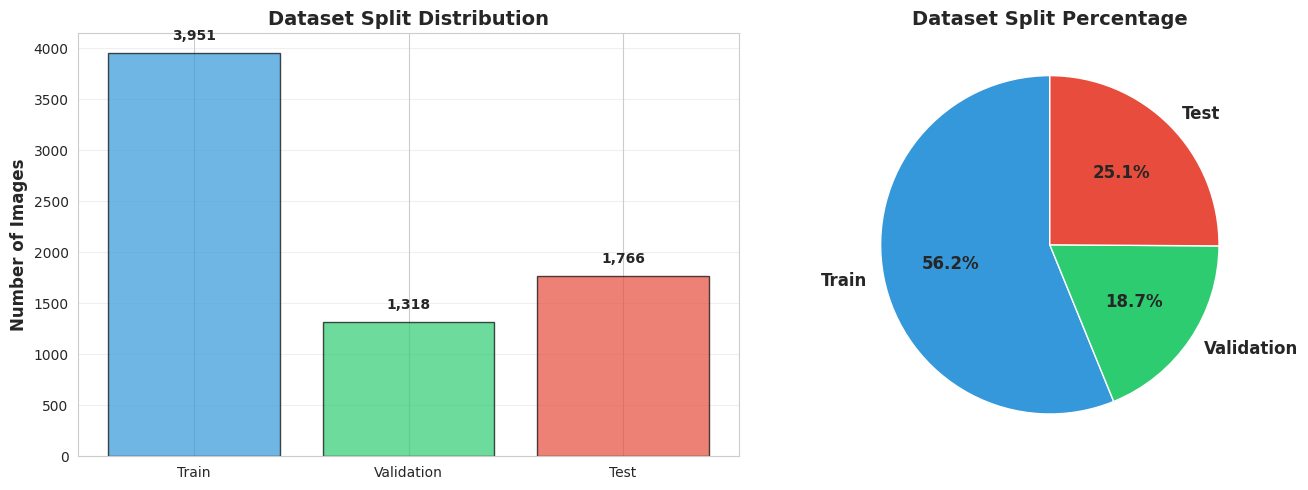

In [ ]:
# Count the number of images in each dataset split
def count_images_in_split(split_name):
    split_path = os.path.join(dataset_path, split_name, 'images')
    if os.path.exists(split_path):
        images = [f for f in os.listdir(split_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        return len(images)
    return 0

train_count = count_images_in_split('train')
valid_count = count_images_in_split('valid')
test_count = count_images_in_split('test')

print("Dataset Split Statistics:")
print("="*50)
print(f"Training Images:   {train_count:,}")
print(f"Validation Images: {valid_count:,}")
print(f"Test Images:       {test_count:,}")
print(f"Total Images:      {train_count + valid_count + test_count:,}")

# Create visualization of the dataset split distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart showing image counts
splits = ['Train', 'Validation', 'Test']
counts = [train_count, valid_count, test_count]
colors = ['#3498db', '#2ecc71', '#e74c3c']

ax[0].bar(splits, counts, color=colors, alpha=0.7, edgecolor='black')
ax[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', alpha=0.3)

for i, (split, count) in enumerate(zip(splits, counts)):
    ax[0].text(i, count + 100, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart showing percentage distribution
ax[1].pie(counts, labels=splits, colors=colors, autopct='%1.1f%%', startangle=90,
          textprops={'fontsize': 12, 'fontweight': 'bold'})
ax[1].set_title('Dataset Split Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze the class distribution in the training set
def analyze_class_distribution(split_name='train'):
    labels_path = os.path.join(dataset_path, split_name, 'labels')
    class_counts = Counter()
    total_objects = 0
    images_with_objects = 0
    objects_per_image = []

    label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]

    for label_file in label_files:
        with open(os.path.join(labels_path, label_file), 'r') as f:
            lines = f.readlines()
            if lines:
                images_with_objects += 1
                objects_per_image.append(len(lines))

            for line in lines:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
                total_objects += 1

    return class_counts, total_objects, images_with_objects, objects_per_image

class_counts, total_objects, images_with_objects, objects_per_image = analyze_class_distribution('train')

print("Class Distribution Analysis (Training Set):")
print("="*50)
print(f"Total Objects: {total_objects:,}")
print(f"Images with Objects: {images_with_objects:,}")
print(f"Average Objects per Image: {np.mean(objects_per_image):.2f}")
print(f"Maximum Objects in Single Image: {max(objects_per_image)}")
print(f"Minimum Objects in Single Image: {min(objects_per_image)}")
print("\nClass Distribution:")

for class_id, count in sorted(class_counts.items()):
    class_name = class_names[class_id]
    percentage = (count / total_objects) * 100
    print(f"  {class_name:15s}: {count:6,} ({percentage:5.2f}%)")

Class Distribution Analysis (Training Set):
Total Objects: 15,090
Images with Objects: 3,951
Average Objects per Image: 3.82
Maximum Objects in Single Image: 35
Minimum Objects in Single Image: 1

Class Distribution:
  head           :  3,575 (23.69%)
  helmet         : 11,171 (74.03%)
  person         :    344 ( 2.28%)


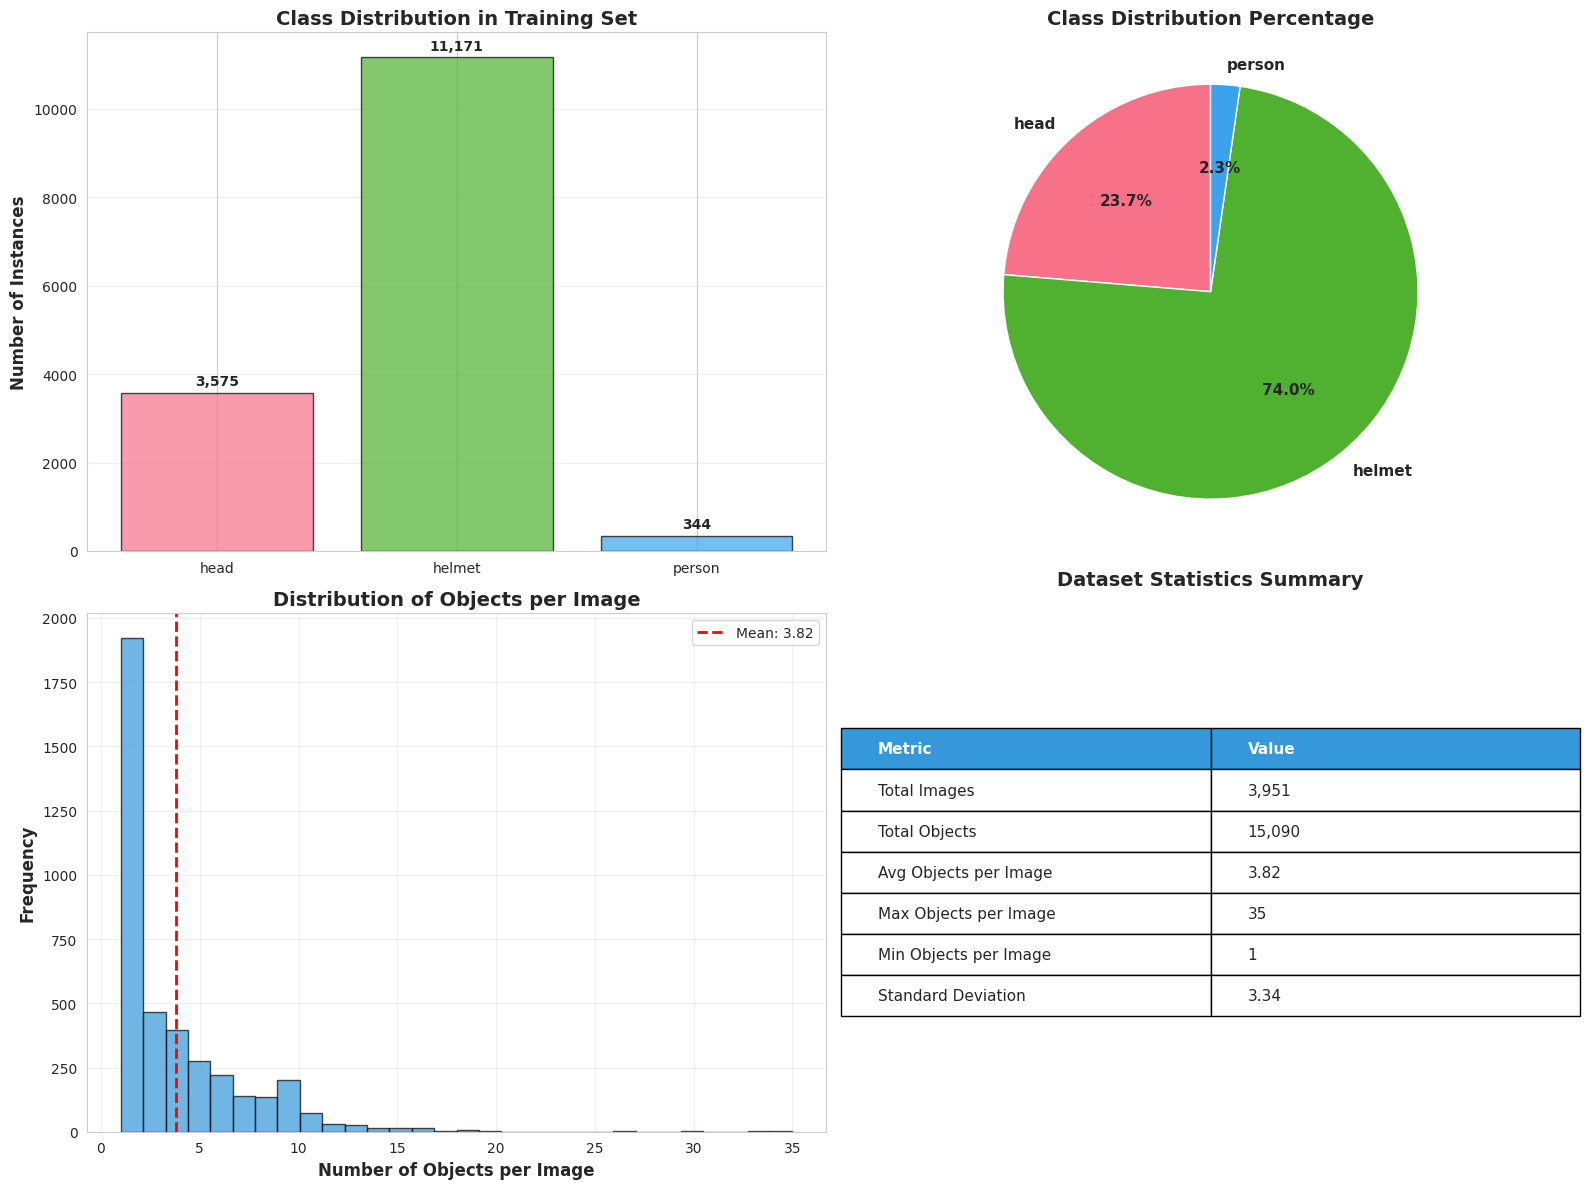

In [ ]:
# Create visualizations for class distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Class distribution bar chart
class_labels = [class_names[i] for i in sorted(class_counts.keys())]
class_values = [class_counts[i] for i in sorted(class_counts.keys())]
colors_palette = sns.color_palette('husl', len(class_labels))

axes[0, 0].bar(class_labels, class_values, color=colors_palette, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (label, value) in enumerate(zip(class_labels, class_values)):
    axes[0, 0].text(i, value + 100, f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Class distribution pie chart
axes[0, 1].pie(class_values, labels=class_labels, colors=colors_palette, autopct='%1.1f%%',
               startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0, 1].set_title('Class Distribution Percentage', fontsize=14, fontweight='bold')

# Objects per image histogram
axes[1, 0].hist(objects_per_image, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.mean(objects_per_image), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(objects_per_image):.2f}')
axes[1, 0].set_xlabel('Number of Objects per Image', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribution of Objects per Image', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics table
axes[1, 1].axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Total Images', f'{train_count:,}'],
    ['Total Objects', f'{total_objects:,}'],
    ['Avg Objects per Image', f'{np.mean(objects_per_image):.2f}'],
    ['Max Objects per Image', f'{max(objects_per_image)}'],
    ['Min Objects per Image', f'{min(objects_per_image)}'],
    ['Standard Deviation', f'{np.std(objects_per_image):.2f}']
]

table = axes[1, 1].table(cellText=summary_data, cellLoc='left', loc='center',
                         colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style the header row
for i in range(2):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 1].set_title('Dataset Statistics Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

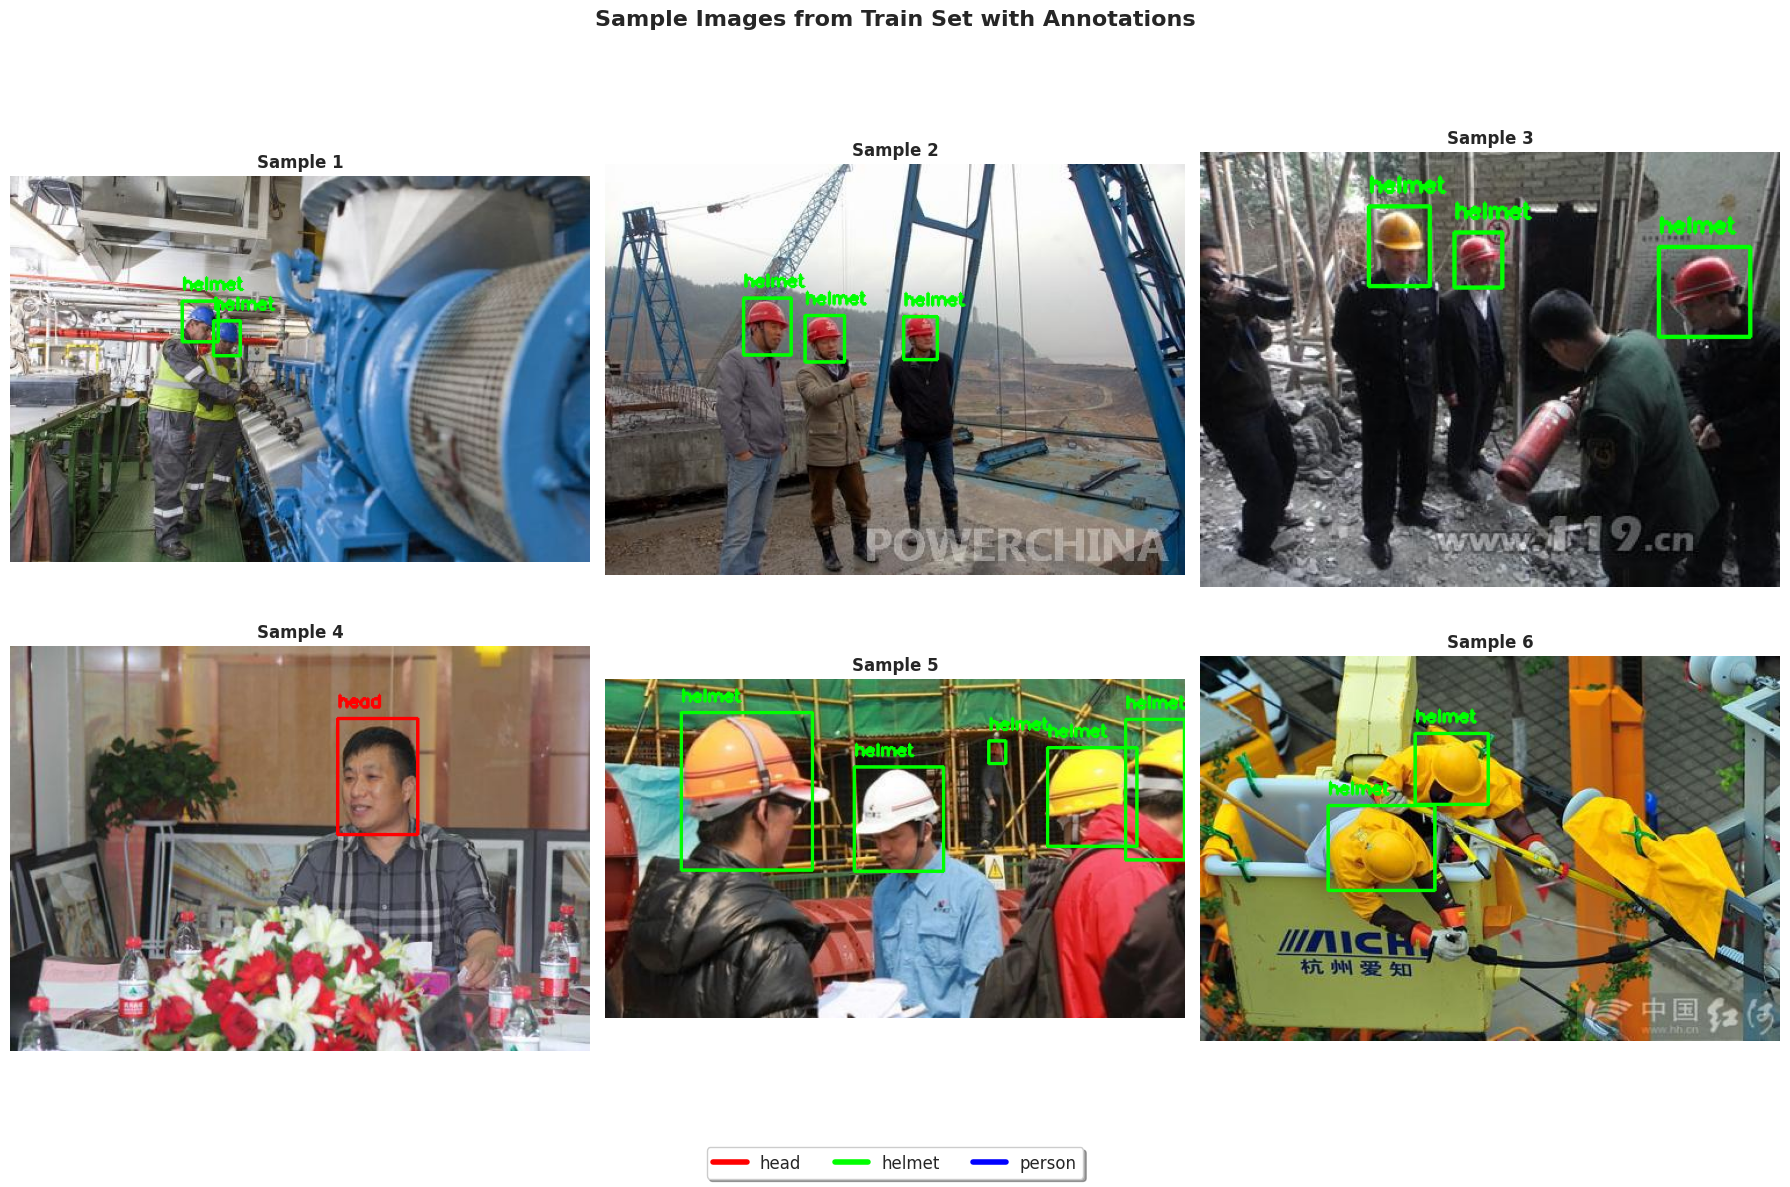

In [ ]:
# Visualize sample images with their annotations
def visualize_samples(split_name='train', num_samples=6):
    images_path = os.path.join(dataset_path, split_name, 'images')
    labels_path = os.path.join(dataset_path, split_name, 'labels')

    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors_map = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255)
    }

    for idx, img_file in enumerate(sample_files):
        # Load the image
        img_path = os.path.join(images_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Load the corresponding annotations
        label_file = img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    # Draw bounding box on the image
                    color = colors_map.get(class_id, (255, 255, 255))
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    # Add class label
                    label = class_names[class_id]
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                               0.5, color, 2)

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Sample {idx+1}', fontsize=12, fontweight='bold')

    # Add legend for the color coding
    legend_elements = [plt.Line2D([0], [0], color=tuple(c/255 for c in colors_map[i]),
                                  lw=4, label=class_names[i])
                      for i in range(len(class_names))]
    fig.legend(handles=legend_elements, loc='lower center', ncol=len(class_names),
              fontsize=12, frameon=True, fancybox=True, shadow=True)

    plt.suptitle(f'Sample Images from {split_name.capitalize()} Set with Annotations',
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

visualize_samples('train', num_samples=6)

## Step 4: Model Training - Baseline Model

In this step, we will train our first YOLOv8 model with default parameters to establish a baseline for comparison.

In [ ]:
# Initialize the YOLOv8 baseline model
# We are using the nano version (yolov8n.pt) for faster training
# Other available versions: yolov8s.pt (small), yolov8m.pt (medium), yolov8l.pt (large), yolov8x.pt (extra large)
model_baseline = YOLO('yolov8n.pt')

print("YOLOv8 Baseline Model has been loaded successfully.")
print(f"Model Architecture: YOLOv8n (Nano)")
print(f"Parameters: Approximately 3.2 million")
print(f"Model Size: Approximately 6 MB")

YOLOv8 Baseline Model has been loaded successfully.
Model Architecture: YOLOv8n (Nano)
Parameters: Approximately 3.2 million
Model Size: Approximately 6 MB


In [ ]:
# Train the baseline model
print("Starting Baseline Model Training...")
print("="*50)

results_baseline = model_baseline.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name='ppe_baseline',
    patience=10,
    save=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2,
    project='runs/detect',
    exist_ok=True,
    pretrained=True,
    optimizer='auto',
    verbose=True,
    seed=42,
    deterministic=True,
    single_cls=False,
    rect=False,
    cos_lr=False,
    close_mosaic=10,
    resume=False,
    amp=True,
    fraction=1.0,
    profile=False,
    freeze=None,
)

print("\nBaseline Model Training has been completed successfully.")

Starting Baseline Model Training...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/hard-hat-dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

## Step 5: Model Training - Tuned Model

Now we will train an optimized model with carefully selected hyperparameters to improve performance.

In [ ]:
# Initialize the YOLOv8 tuned model
# We are using the small version (yolov8s.pt) for better performance
model_tuned = YOLO('yolov8s.pt')

print("YOLOv8 Tuned Model has been loaded successfully.")
print(f"Model Architecture: YOLOv8s (Small)")
print(f"Parameters: Approximately 11.2 million")
print(f"Model Size: Approximately 22 MB")

YOLOv8 Tuned Model has been loaded successfully.
Model Architecture: YOLOv8s (Small)
Parameters: Approximately 11.2 million
Model Size: Approximately 22 MB


In [ ]:
# Train the tuned model with optimized hyperparameters
print("Starting Tuned Model Training with Optimized Hyperparameters...")
print("="*50)

results_tuned = model_tuned.train(
    data=data_yaml_path,
    epochs=100,
    imgsz=640,
    batch=16,
    name='ppe_tuned',
    patience=20,
    save=True,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=4,
    project='runs/detect',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    verbose=True,
    seed=42,
    deterministic=True,
    single_cls=False,
    rect=False,
    cos_lr=True,
    close_mosaic=15,
    resume=False,
    amp=True,
    fraction=1.0,
    profile=False,
    freeze=None,
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    pose=12.0,
    kobj=1.0,
    label_smoothing=0.0,
    nbs=64,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0,
)

print("\nTuned Model Training has been completed successfully.")

Starting Tuned Model Training with Optimized Hyperparameters...
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/hard-hat-dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=Fal

## Step 6: Model Evaluation and Performance Metrics

In this step, we will evaluate both models on the validation set and compare their performance using standard metrics.

In [ ]:
# Load the best weights for both models
baseline_best = YOLO('runs/detect/ppe_baseline/weights/best.pt')
tuned_best = YOLO('runs/detect/ppe_tuned/weights/best.pt')

print("Best model weights have been loaded successfully for both models.")

Best model weights have been loaded successfully for both models.


In [ ]:
# Validate the baseline model on the validation set
print("Evaluating Baseline Model on Validation Set...")
print("="*50)

metrics_baseline = baseline_best.val(
    data=data_yaml_path,
    split='val',
    imgsz=640,
    batch=16,
    conf=0.25,
    iou=0.6,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2,
    save_json=True,
    save_hybrid=False,
    verbose=True,
    plots=True,
)

print("\nBaseline Model Evaluation has been completed.")

Evaluating Baseline Model on Validation Set...
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1127.6±541.5 MB/s, size: 37.0 KB)
val: Scanning /content/hard-hat-dataset/valid/labels.cache... 1318 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1318/1318 2.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 83/83 10.1it/s 8.2s
                   all       1318       5141      0.633      0.615      0.641      0.469
                  head        256       1299      0.938      0.908      0.948      0.698
                helmet       1201       3713      0.961      0.935      0.971      0.707
                person         46        129          0          0    0.00491    0.00343
Spee

In [ ]:
# Validate the tuned model on the validation set
print("Evaluating Tuned Model on Validation Set...")
print("="*50)

metrics_tuned = tuned_best.val(
    data=data_yaml_path,
    split='val',
    imgsz=640,
    batch=16,
    conf=0.25,
    iou=0.6,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2,
    save_json=True,
    save_hybrid=False,
    verbose=True,
    plots=True,
)

print("\nTuned Model Evaluation has been completed.")

Evaluating Tuned Model on Validation Set...
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1049.9±428.8 MB/s, size: 30.2 KB)
val: Scanning /content/hard-hat-dataset/valid/labels.cache... 1318 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1318/1318 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 83/83 8.3it/s 10.1s
                   all       1318       5141      0.654      0.629       0.65      0.476
                  head        256       1299      0.917      0.921       0.95      0.705
                helmet       1201       3713      0.956      0.949      0.974      0.706
                person         46        129     0.0892     0.0155     0.0268     0.0174
Speed

In [ ]:
# Extract and compare performance metrics from both models
def extract_metrics(metrics):
    return {
        'mAP50': metrics.box.map50,
        'mAP50-95': metrics.box.map,
        'Precision': metrics.box.mp,
        'Recall': metrics.box.mr,
        'F1-Score': 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr) if (metrics.box.mp + metrics.box.mr) > 0 else 0
    }

baseline_metrics = extract_metrics(metrics_baseline)
tuned_metrics = extract_metrics(metrics_tuned)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Baseline Model': baseline_metrics,
    'Tuned Model': tuned_metrics,
    'Improvement': {k: tuned_metrics[k] - baseline_metrics[k] for k in baseline_metrics.keys()}
})

print("\nModel Performance Comparison:")
print("="*70)
print(comparison_df.to_string())
print("="*70)


Model Performance Comparison:
           Baseline Model  Tuned Model  Improvement
mAP50            0.641085     0.650384     0.009299
mAP50-95         0.469453     0.476214     0.006761
Precision        0.632977     0.653901     0.020924
Recall           0.614581     0.628582     0.014001
F1-Score         0.623643     0.640992     0.017348


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


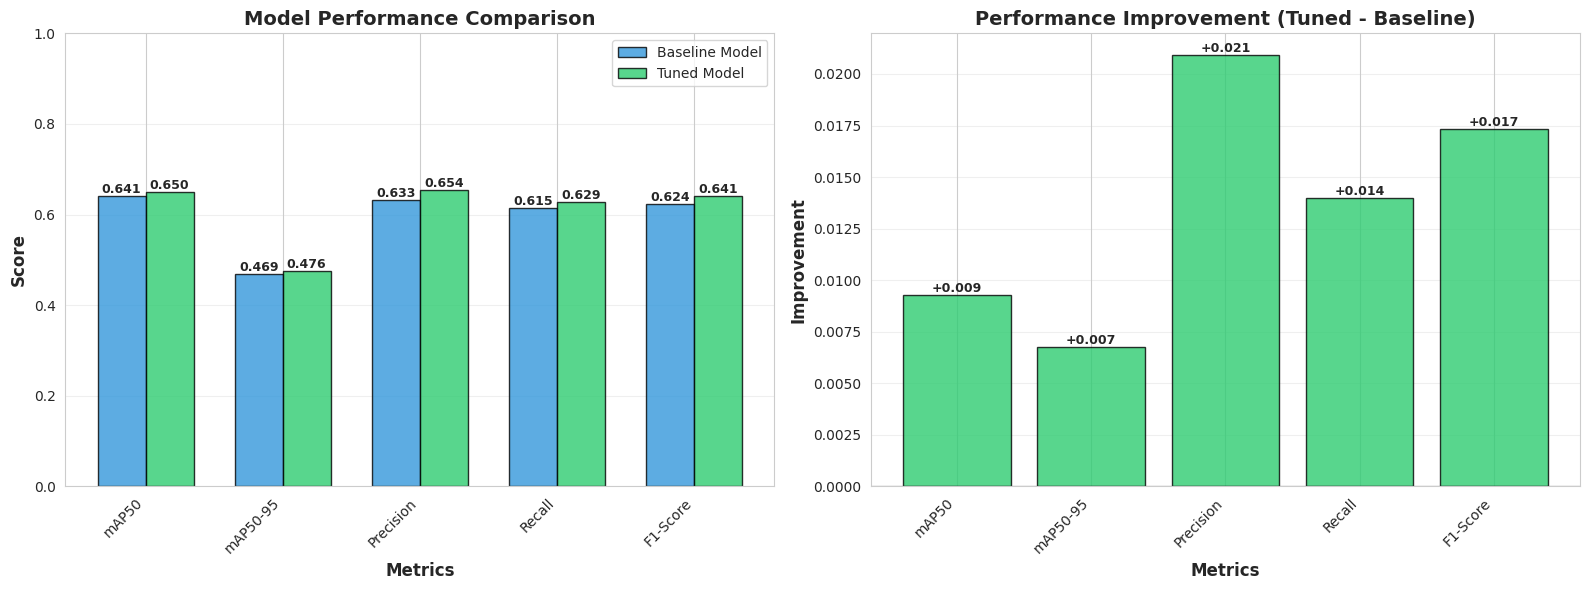

In [ ]:
# Create visualizations comparing the performance of both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison of metrics
x = np.arange(len(baseline_metrics))
width = 0.35
metrics_names = list(baseline_metrics.keys())
baseline_values = list(baseline_metrics.values())
tuned_values = list(tuned_metrics.values())

bars1 = axes[0].bar(x - width/2, baseline_values, width, label='Baseline Model',
                    color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, tuned_values, width, label='Tuned Model',
                    color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Add value labels on the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Visualization of improvement from baseline to tuned model
improvements = [tuned_metrics[k] - baseline_metrics[k] for k in metrics_names]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]

bars3 = axes[1].bar(metrics_names, improvements, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Improvement', fontsize=12, fontweight='bold')
axes[1].set_title('Performance Improvement (Tuned - Baseline)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels showing the improvement
for bar in bars3:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.3f}', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

Training Results Visualization:

Baseline Model Results:


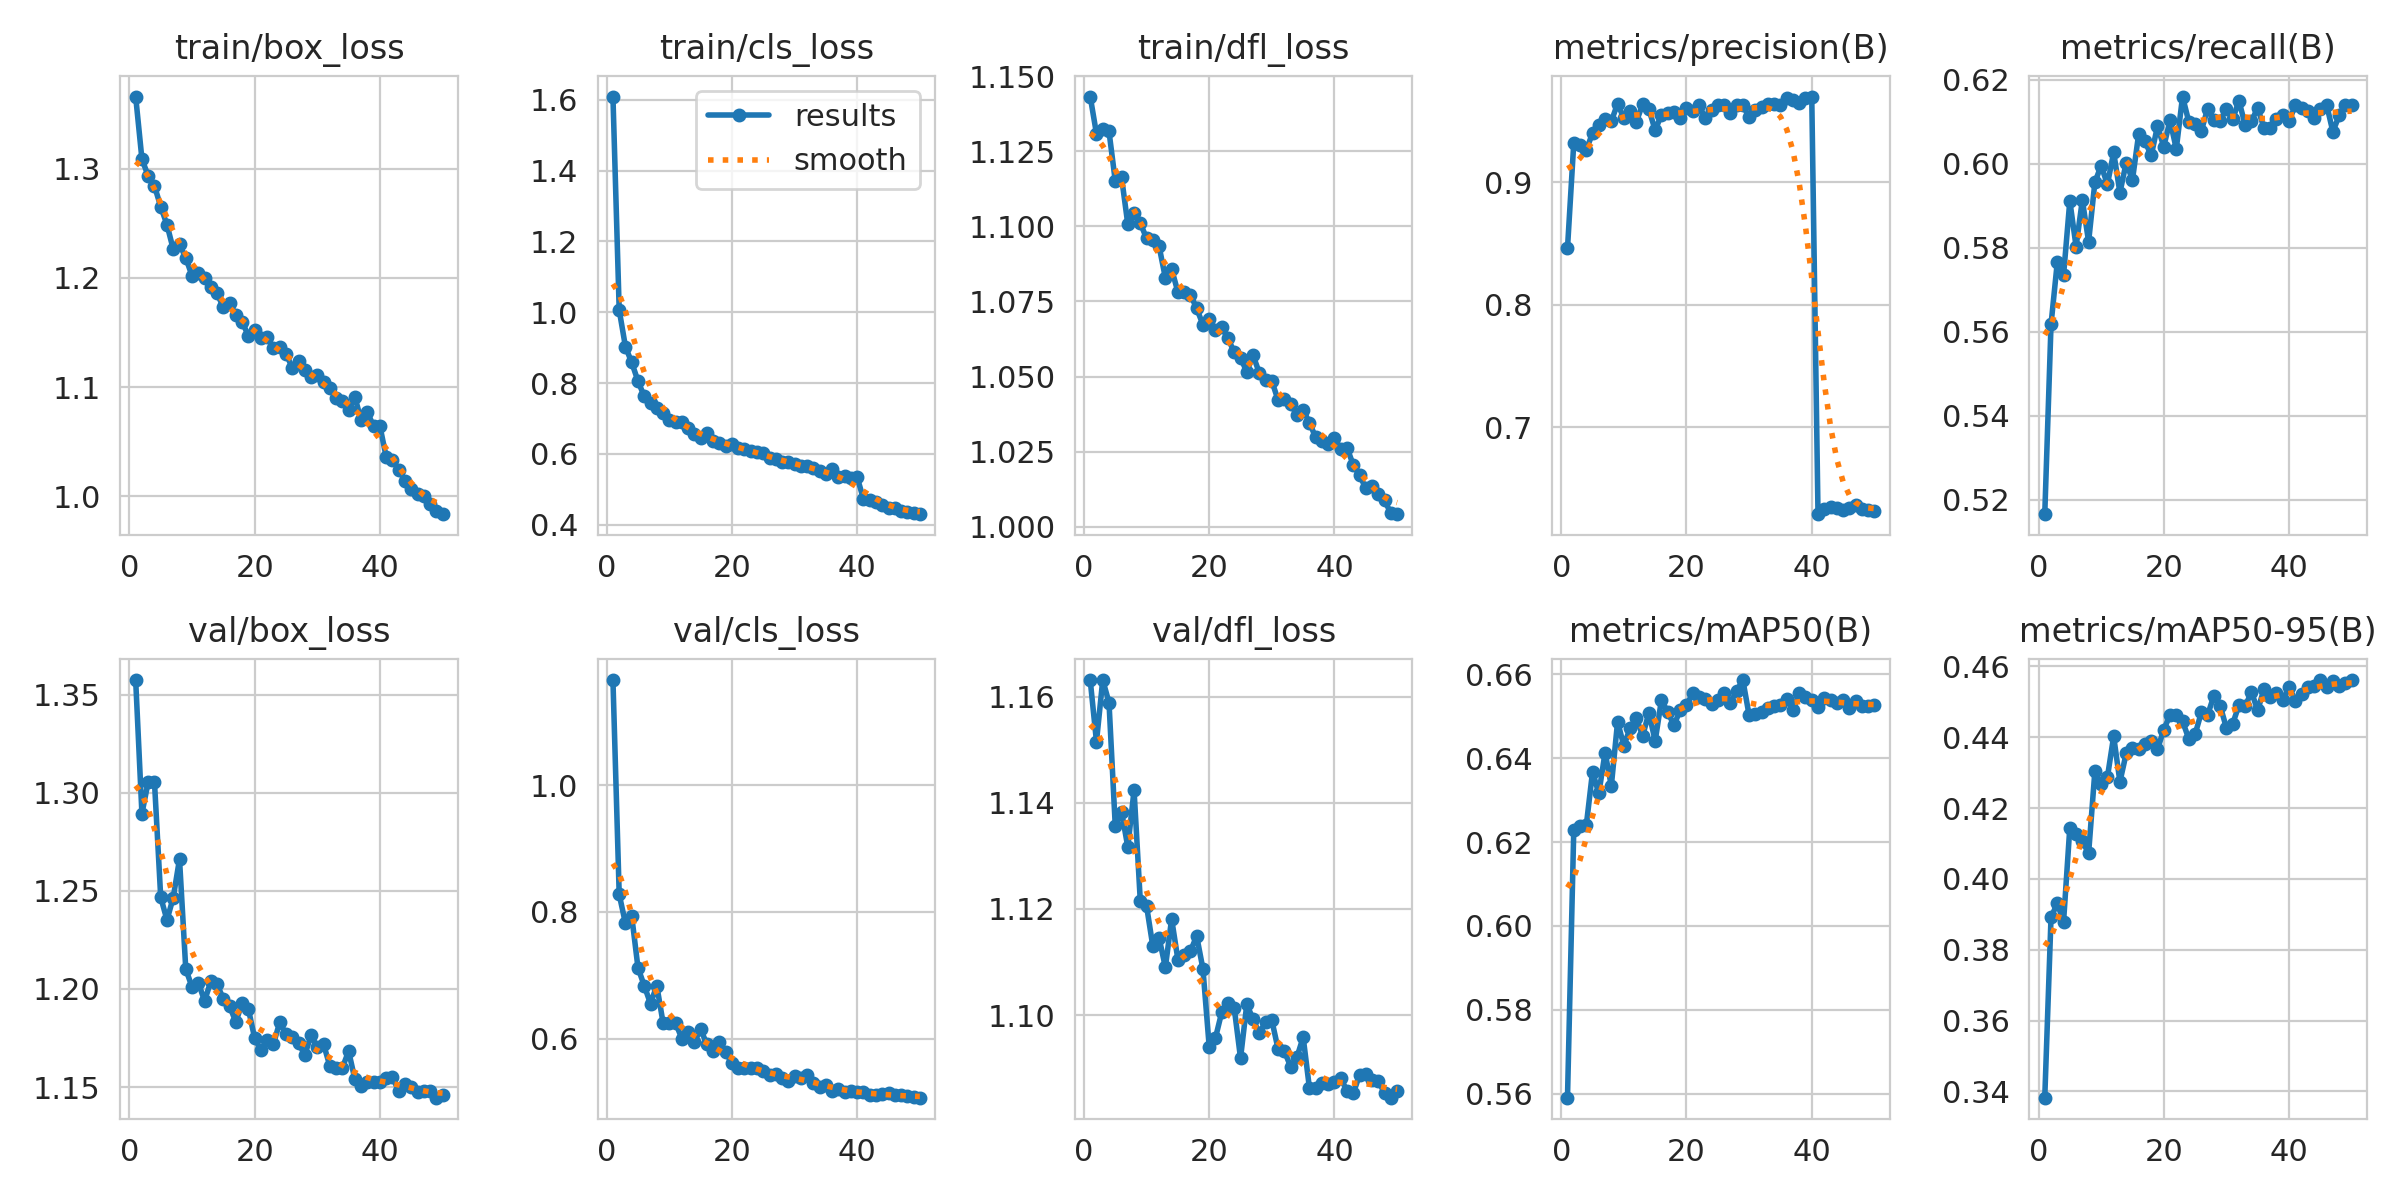


Tuned Model Results:


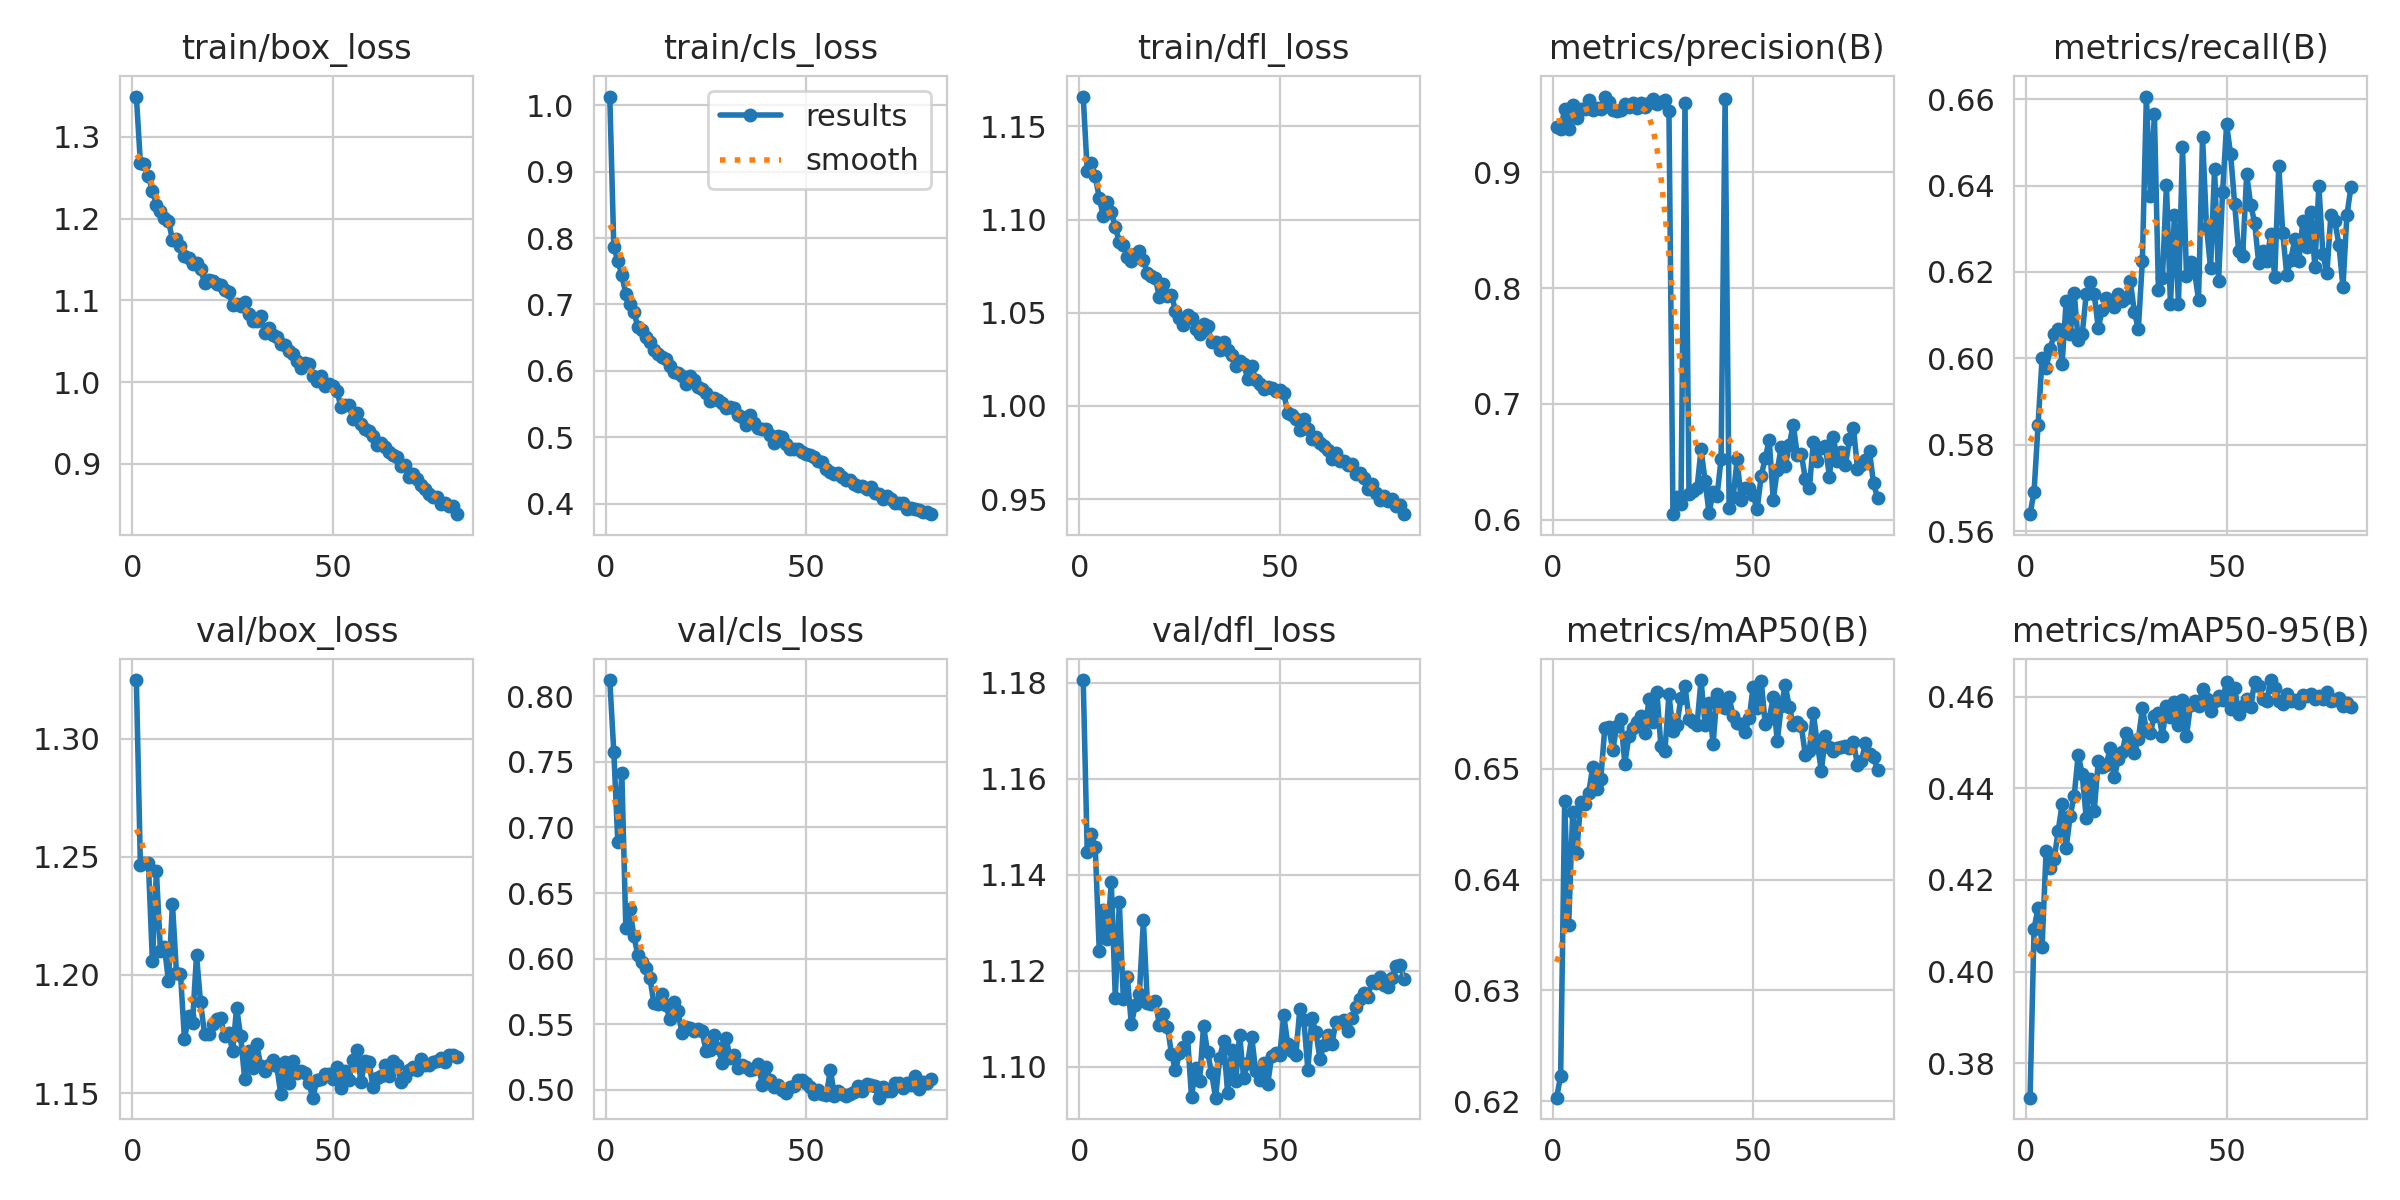

In [ ]:
# Display training results and learning curves
from IPython.display import Image as IPImage, display

print("Training Results Visualization:")
print("="*50)

print("\nBaseline Model Results:")
baseline_results_img = 'runs/detect/ppe_baseline/results.png'
if os.path.exists(baseline_results_img):
    display(IPImage(filename=baseline_results_img, width=1000))
else:
    print("Results image not found for baseline model.")

print("\nTuned Model Results:")
tuned_results_img = 'runs/detect/ppe_tuned/results.png'
if os.path.exists(tuned_results_img):
    display(IPImage(filename=tuned_results_img, width=1000))
else:
    print("Results image not found for tuned model.")

Confusion Matrices:


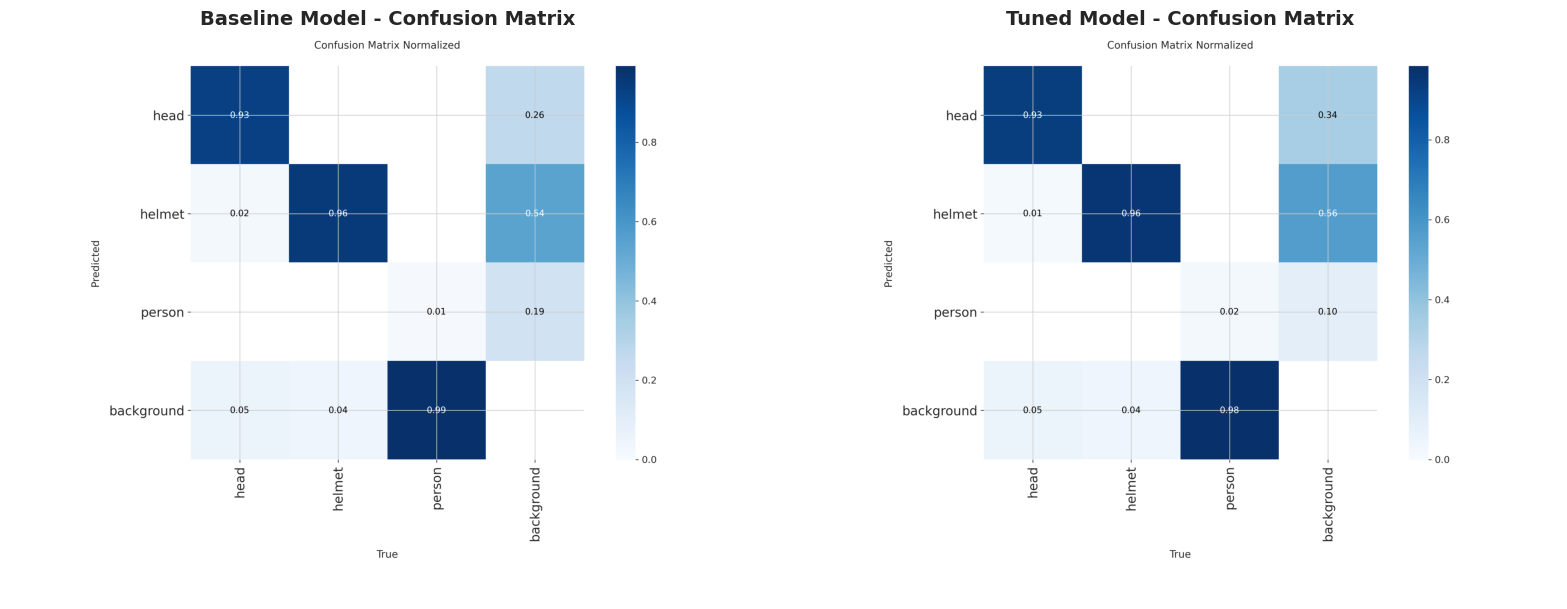

In [ ]:
# Display confusion matrices for both models
print("Confusion Matrices:")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline model confusion matrix
baseline_cm_path = 'runs/detect/ppe_baseline/confusion_matrix_normalized.png'
if os.path.exists(baseline_cm_path):
    baseline_cm = plt.imread(baseline_cm_path)
    axes[0].imshow(baseline_cm)
    axes[0].axis('off')
    axes[0].set_title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'Confusion Matrix Not Found', ha='center', va='center')
    axes[0].axis('off')

# Tuned model confusion matrix
tuned_cm_path = 'runs/detect/ppe_tuned/confusion_matrix_normalized.png'
if os.path.exists(tuned_cm_path):
    tuned_cm = plt.imread(tuned_cm_path)
    axes[1].imshow(tuned_cm)
    axes[1].axis('off')
    axes[1].set_title('Tuned Model - Confusion Matrix', fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'Confusion Matrix Not Found', ha='center', va='center')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

PRECISION-RECALL CURVES COMPARISON

Baseline PR Curve: Found
Tuned PR Curve: Found


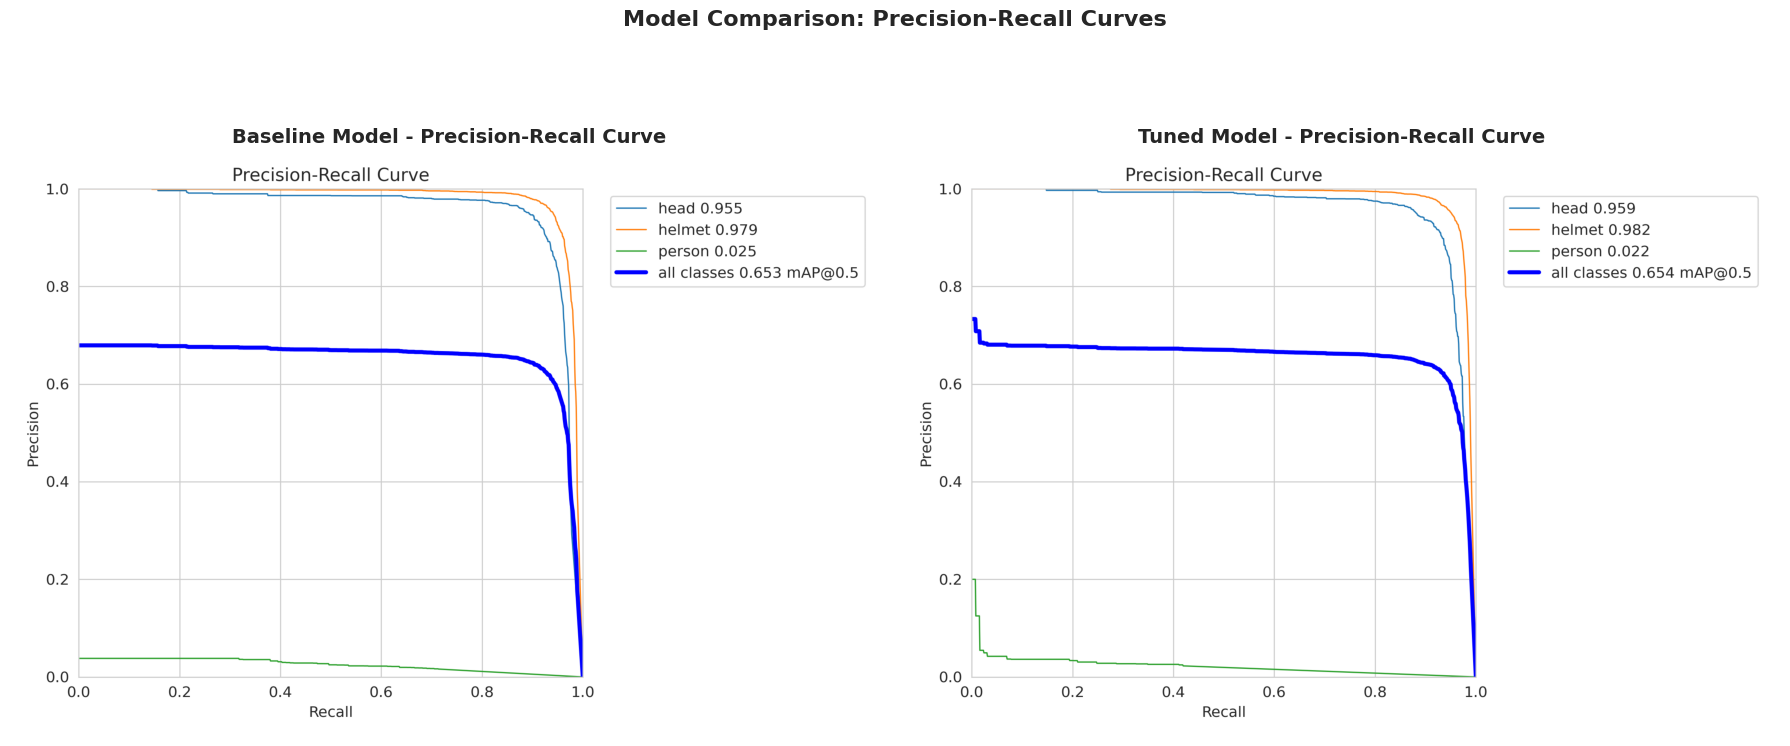


ADDITIONAL TRAINING CURVES

Baseline Model Curves:
  F1 Score Curve: Found
  Precision Curve: Found
  Recall Curve: Found

Tuned Model Curves:
  F1 Score Curve: Found
  Precision Curve: Found
  Recall Curve: Found


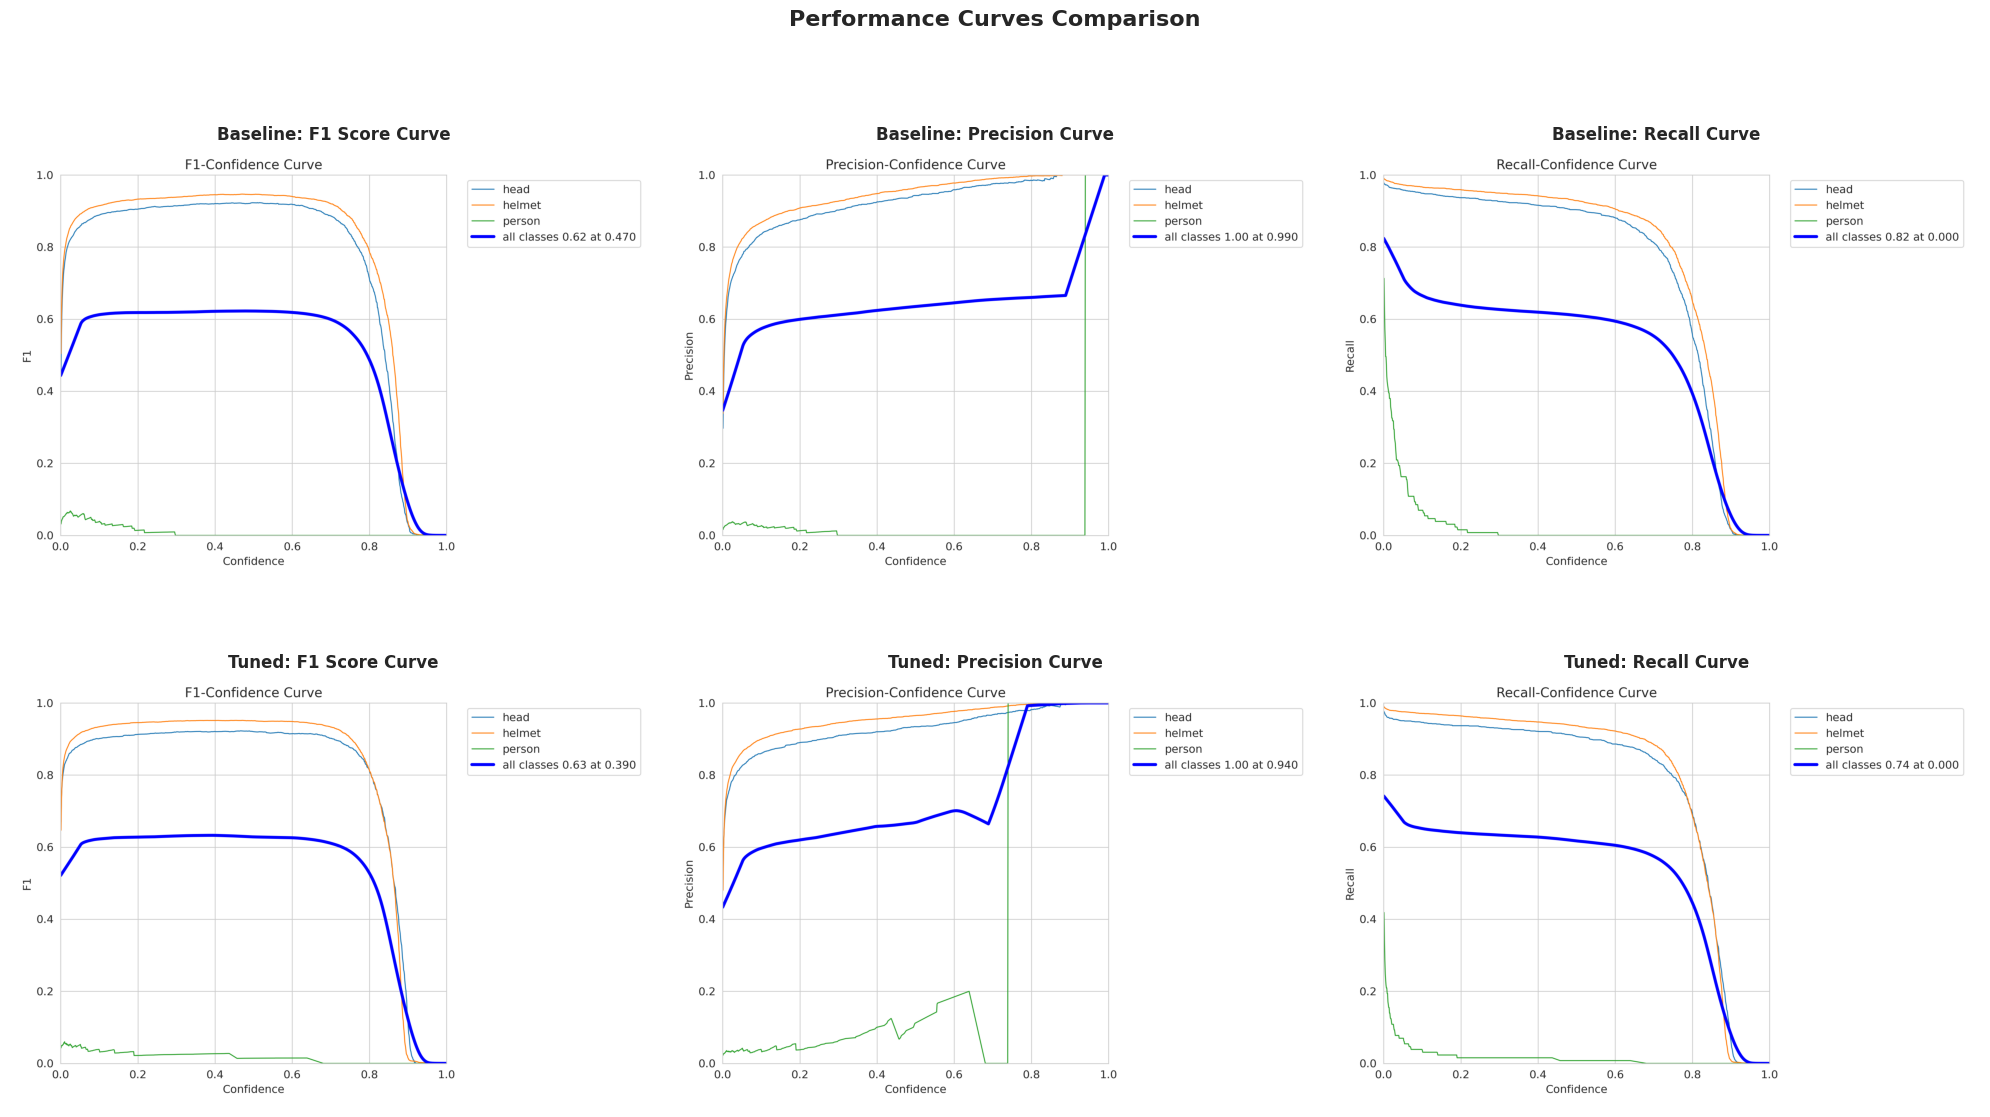


CONFUSION MATRICES
Baseline Confusion Matrix: Found
Baseline Normalized Confusion Matrix: Found
Tuned Confusion Matrix: Found
Tuned Normalized Confusion Matrix: Found


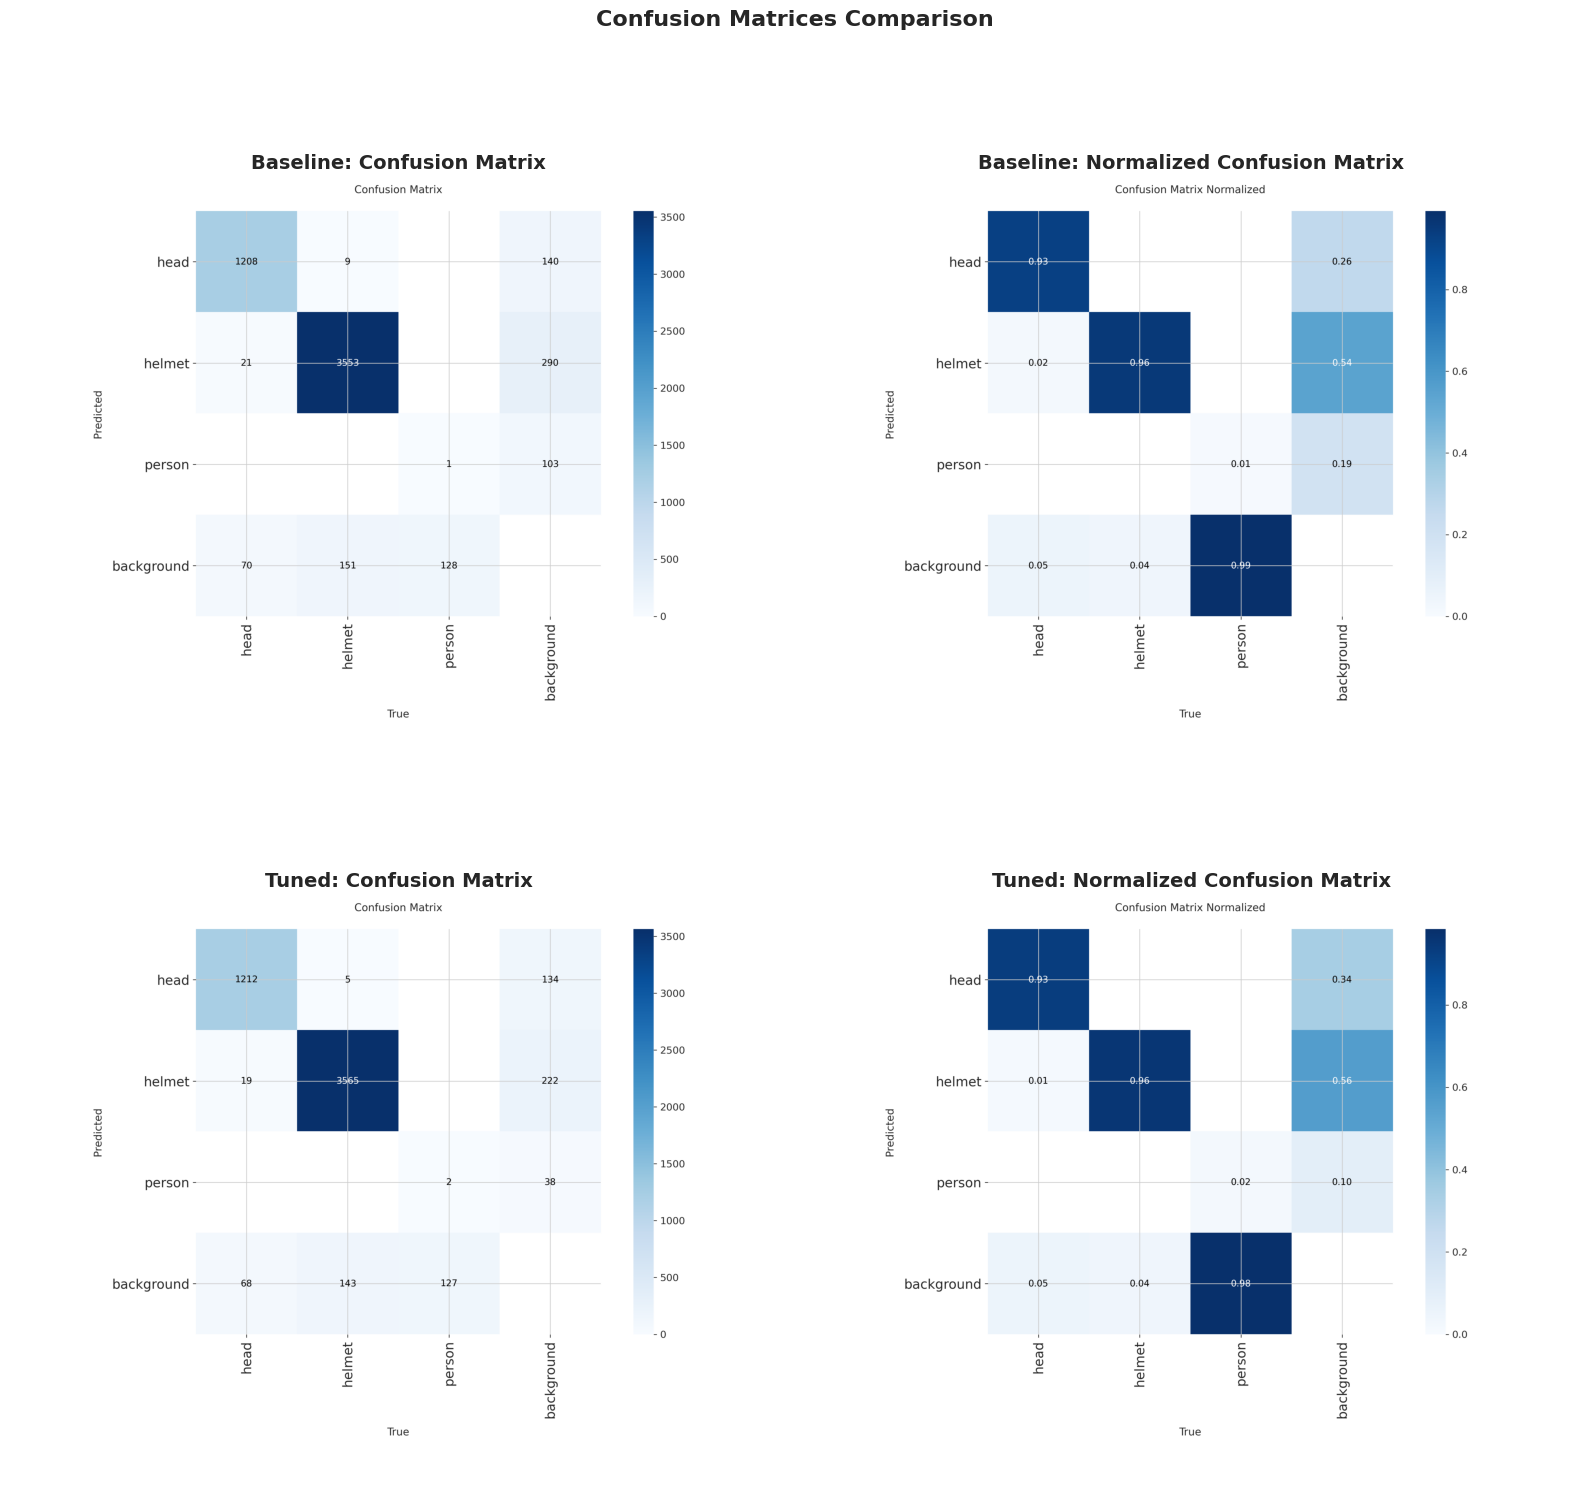


TRAINING RESULTS SUMMARY
Baseline Training Metrics: Found
Tuned Training Metrics: Found


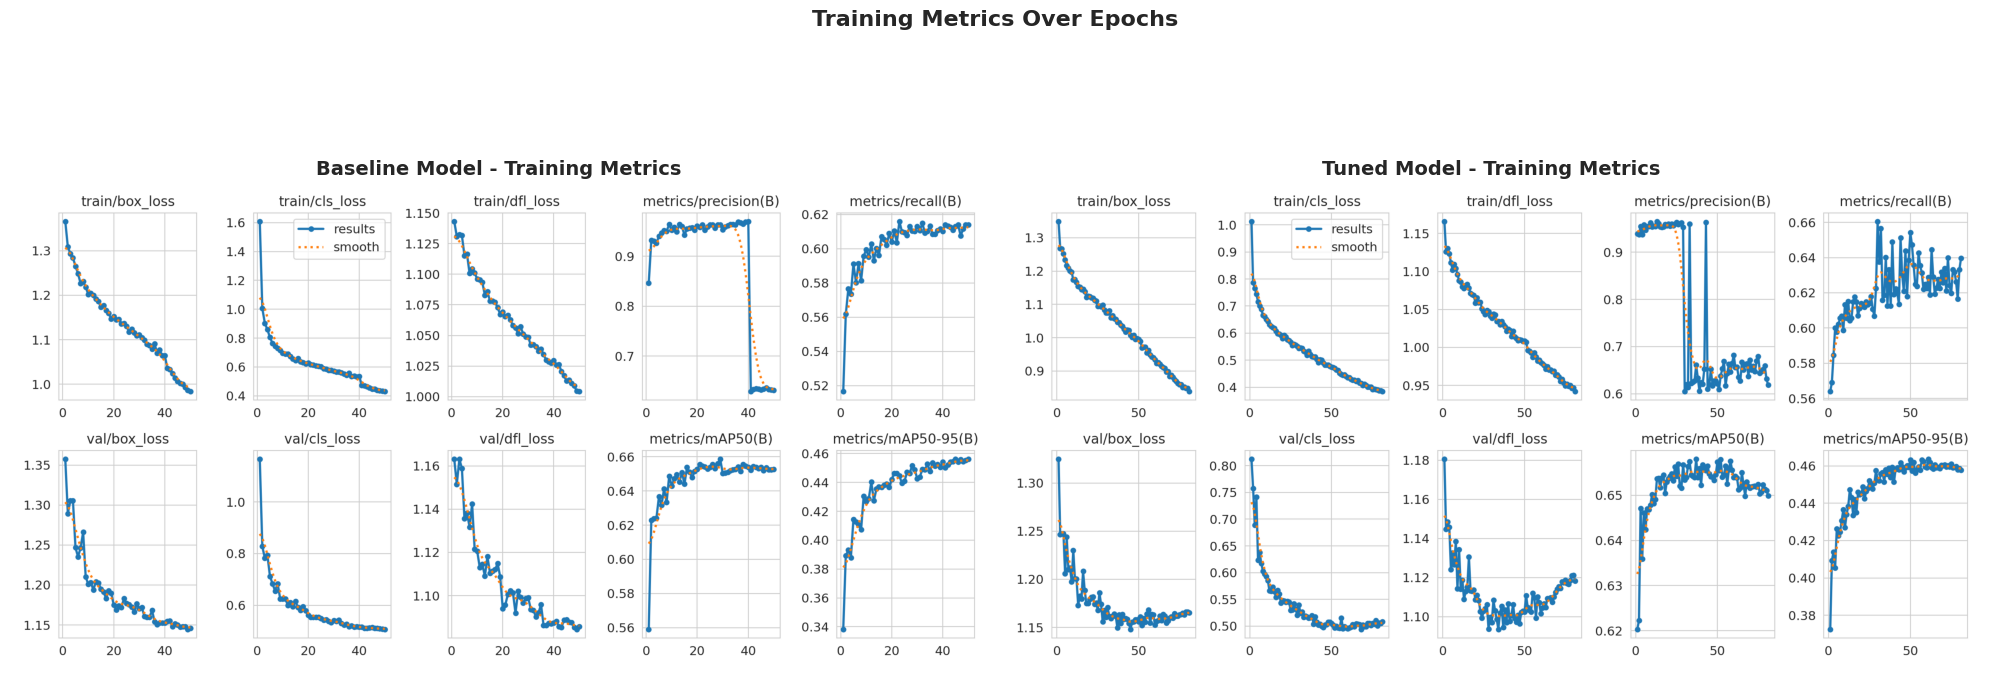


ALL VISUALIZATIONS DISPLAYED SUCCESSFULLY


In [ ]:
import os
import matplotlib.pyplot as plt

print("="*70)
print("PRECISION-RECALL CURVES COMPARISON")
print("="*70)

# Correct file paths
baseline_pr_path = 'runs/detect/ppe_baseline/BoxPR_curve.png'
tuned_pr_path = 'runs/detect/ppe_tuned/BoxPR_curve.png'

# Check if files exist
baseline_exists = os.path.exists(baseline_pr_path)
tuned_exists = os.path.exists(tuned_pr_path)

print(f"\nBaseline PR Curve: {'Found' if baseline_exists else 'Not Found'}")
print(f"Tuned PR Curve: {'Found' if tuned_exists else 'Not Found'}")

# Display the curves
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Baseline model PR curve
if baseline_exists:
    baseline_pr = plt.imread(baseline_pr_path)
    axes[0].imshow(baseline_pr)
    axes[0].axis('off')
    axes[0].set_title('Baseline Model - Precision-Recall Curve', fontsize=14, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'PR Curve Not Found', ha='center', va='center', fontsize=14)
    axes[0].axis('off')
    axes[0].set_title('Baseline Model', fontsize=14, fontweight='bold')

# Tuned model PR curve
if tuned_exists:
    tuned_pr = plt.imread(tuned_pr_path)
    axes[1].imshow(tuned_pr)
    axes[1].axis('off')
    axes[1].set_title('Tuned Model - Precision-Recall Curve', fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'PR Curve Not Found', ha='center', va='center', fontsize=14)
    axes[1].axis('off')
    axes[1].set_title('Tuned Model', fontsize=14, fontweight='bold')

plt.suptitle('Model Comparison: Precision-Recall Curves', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ADDITIONAL TRAINING CURVES")
print("="*70)

# Display other important curves
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Baseline model curves
baseline_curves = {
    'BoxF1_curve.png': 'F1 Score Curve',
    'BoxP_curve.png': 'Precision Curve',
    'BoxR_curve.png': 'Recall Curve'
}

print("\nBaseline Model Curves:")
for idx, (filename, title) in enumerate(baseline_curves.items()):
    filepath = f'runs/detect/ppe_baseline/{filename}'
    if os.path.exists(filepath):
        img = plt.imread(filepath)
        axes[0, idx].imshow(img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Baseline: {title}', fontsize=12, fontweight='bold')
        print(f"  {title}: Found")
    else:
        axes[0, idx].text(0.5, 0.5, 'Not Found', ha='center', va='center')
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Baseline: {title}', fontsize=12, fontweight='bold')
        print(f"  {title}: Not Found")

# Tuned model curves
print("\nTuned Model Curves:")
for idx, (filename, title) in enumerate(baseline_curves.items()):
    filepath = f'runs/detect/ppe_tuned/{filename}'
    if os.path.exists(filepath):
        img = plt.imread(filepath)
        axes[1, idx].imshow(img)
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Tuned: {title}', fontsize=12, fontweight='bold')
        print(f"  {title}: Found")
    else:
        axes[1, idx].text(0.5, 0.5, 'Not Found', ha='center', va='center')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Tuned: {title}', fontsize=12, fontweight='bold')
        print(f"  {title}: Not Found")

plt.suptitle('Performance Curves Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONFUSION MATRICES")
print("="*70)

# Display confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Baseline confusion matrices
baseline_cm_path = 'runs/detect/ppe_baseline/confusion_matrix.png'
baseline_cm_norm_path = 'runs/detect/ppe_baseline/confusion_matrix_normalized.png'

if os.path.exists(baseline_cm_path):
    img = plt.imread(baseline_cm_path)
    axes[0, 0].imshow(img)
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Baseline: Confusion Matrix', fontsize=14, fontweight='bold')
    print("Baseline Confusion Matrix: Found")
else:
    axes[0, 0].text(0.5, 0.5, 'Not Found', ha='center', va='center')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Baseline: Confusion Matrix', fontsize=14, fontweight='bold')

if os.path.exists(baseline_cm_norm_path):
    img = plt.imread(baseline_cm_norm_path)
    axes[0, 1].imshow(img)
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Baseline: Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    print("Baseline Normalized Confusion Matrix: Found")
else:
    axes[0, 1].text(0.5, 0.5, 'Not Found', ha='center', va='center')
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Baseline: Normalized Confusion Matrix', fontsize=14, fontweight='bold')

# Tuned confusion matrices
tuned_cm_path = 'runs/detect/ppe_tuned/confusion_matrix.png'
tuned_cm_norm_path = 'runs/detect/ppe_tuned/confusion_matrix_normalized.png'

if os.path.exists(tuned_cm_path):
    img = plt.imread(tuned_cm_path)
    axes[1, 0].imshow(img)
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Tuned: Confusion Matrix', fontsize=14, fontweight='bold')
    print("Tuned Confusion Matrix: Found")
else:
    axes[1, 0].text(0.5, 0.5, 'Not Found', ha='center', va='center')
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Tuned: Confusion Matrix', fontsize=14, fontweight='bold')

if os.path.exists(tuned_cm_norm_path):
    img = plt.imread(tuned_cm_norm_path)
    axes[1, 1].imshow(img)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Tuned: Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    print("Tuned Normalized Confusion Matrix: Found")
else:
    axes[1, 1].text(0.5, 0.5, 'Not Found', ha='center', va='center')
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Tuned: Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TRAINING RESULTS SUMMARY")
print("="*70)

# Display results.png for both models
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

baseline_results_path = 'runs/detect/ppe_baseline/results.png'
tuned_results_path = 'runs/detect/ppe_tuned/results.png'

if os.path.exists(baseline_results_path):
    img = plt.imread(baseline_results_path)
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Baseline Model - Training Metrics', fontsize=14, fontweight='bold')
    print("Baseline Training Metrics: Found")
else:
    axes[0].text(0.5, 0.5, 'Not Found', ha='center', va='center')
    axes[0].axis('off')
    axes[0].set_title('Baseline Model - Training Metrics', fontsize=14, fontweight='bold')

if os.path.exists(tuned_results_path):
    img = plt.imread(tuned_results_path)
    axes[1].imshow(img)
    axes[1].axis('off')
    axes[1].set_title('Tuned Model - Training Metrics', fontsize=14, fontweight='bold')
    print("Tuned Training Metrics: Found")
else:
    axes[1].text(0.5, 0.5, 'Not Found', ha='center', va='center')
    axes[1].axis('off')
    axes[1].set_title('Tuned Model - Training Metrics', fontsize=14, fontweight='bold')

plt.suptitle('Training Metrics Over Epochs', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ALL VISUALIZATIONS DISPLAYED SUCCESSFULLY")
print("="*70)

## Step 7: Model Inference and Predictions

In this step, we will test our trained models on new images to evaluate their real-world performance.

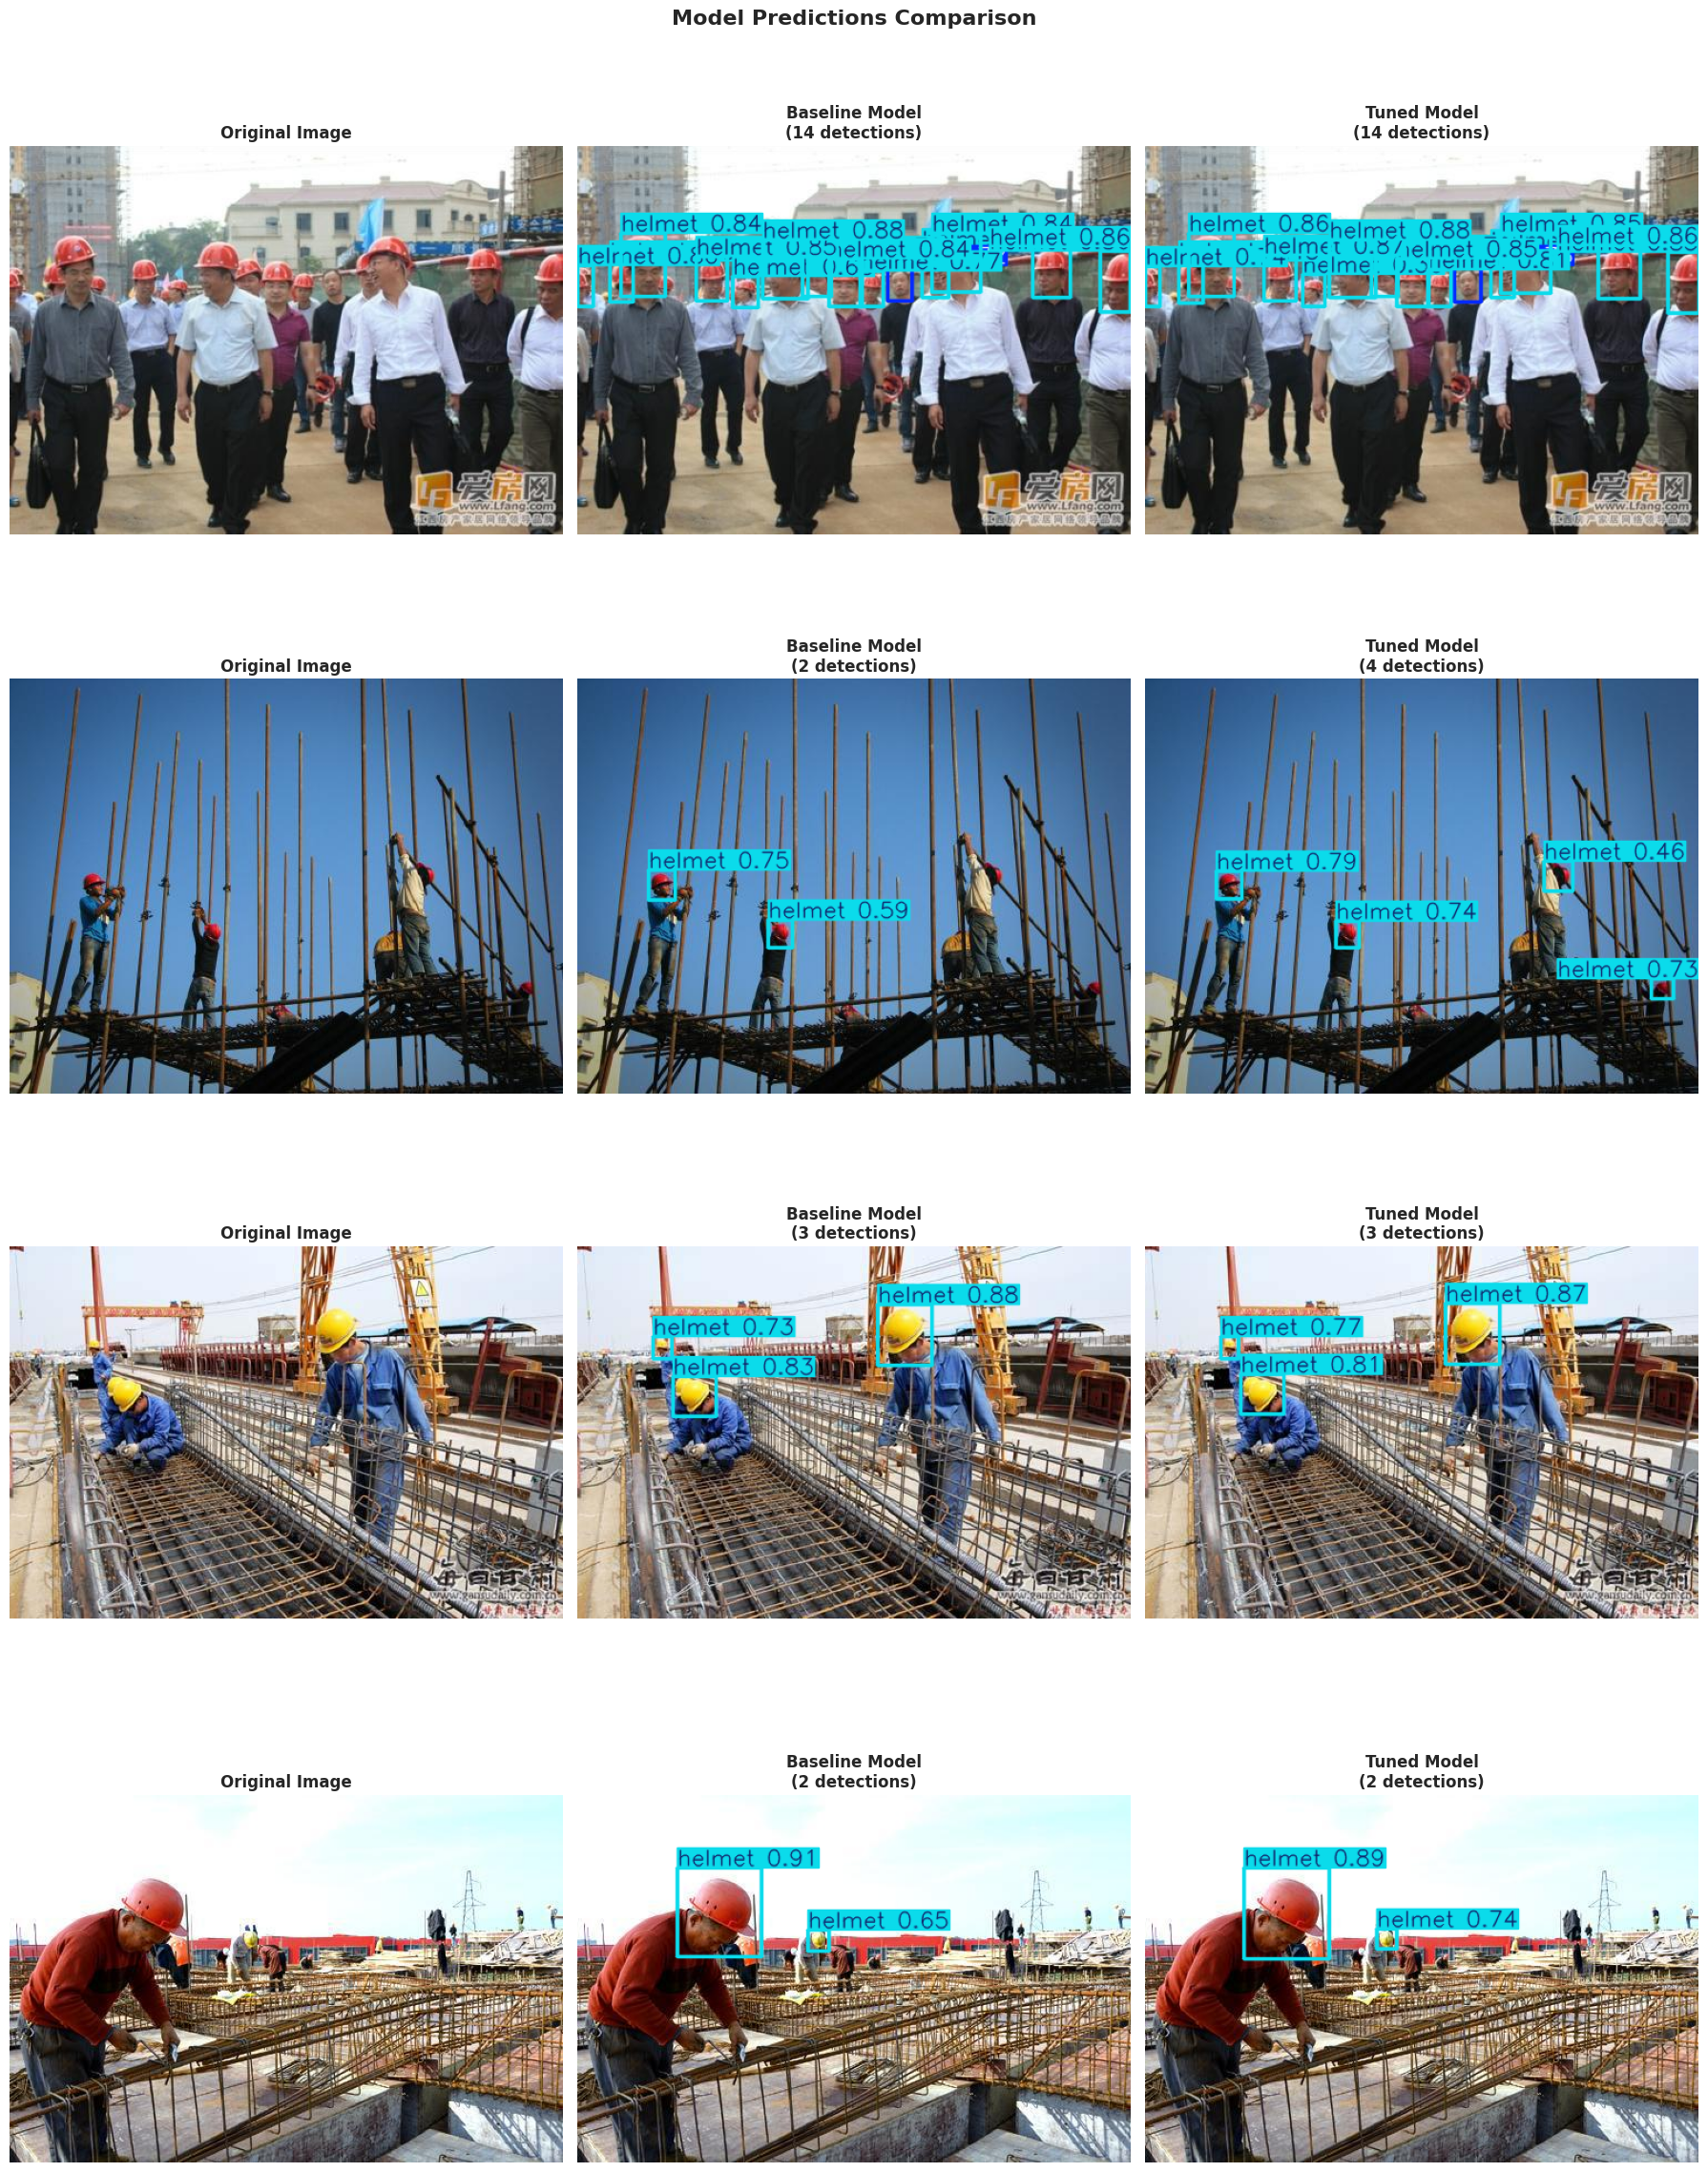

In [ ]:
# Run inference on validation images and compare both models
def run_inference_comparison(num_samples=6):
    test_images_path = os.path.join(dataset_path, 'valid', 'images')
    image_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6*num_samples))

    for idx, img_file in enumerate(sample_files):
        img_path = os.path.join(test_images_path, img_file)

        # Display original image
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title('Original Image', fontsize=12, fontweight='bold')

        # Baseline model prediction
        results_baseline = baseline_best.predict(img_path, conf=0.25, iou=0.6, verbose=False)
        baseline_img = results_baseline[0].plot()
        baseline_img = cv2.cvtColor(baseline_img, cv2.COLOR_BGR2RGB)
        axes[idx, 1].imshow(baseline_img)
        axes[idx, 1].axis('off')
        axes[idx, 1].set_title(f'Baseline Model\n({len(results_baseline[0].boxes)} detections)',
                              fontsize=12, fontweight='bold')

        # Tuned model prediction
        results_tuned = tuned_best.predict(img_path, conf=0.25, iou=0.6, verbose=False)
        tuned_img = results_tuned[0].plot()
        tuned_img = cv2.cvtColor(tuned_img, cv2.COLOR_BGR2RGB)
        axes[idx, 2].imshow(tuned_img)
        axes[idx, 2].axis('off')
        axes[idx, 2].set_title(f'Tuned Model\n({len(results_tuned[0].boxes)} detections)',
                              fontsize=12, fontweight='bold')

    plt.suptitle('Model Predictions Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

run_inference_comparison(num_samples=4)

Upload an image to test the model:


Saving helmetcolours_1500.jpg to helmetcolours_1500.jpg

Running inference on: helmetcolours_1500.jpg
Results saved to /content/runs/detect/predict


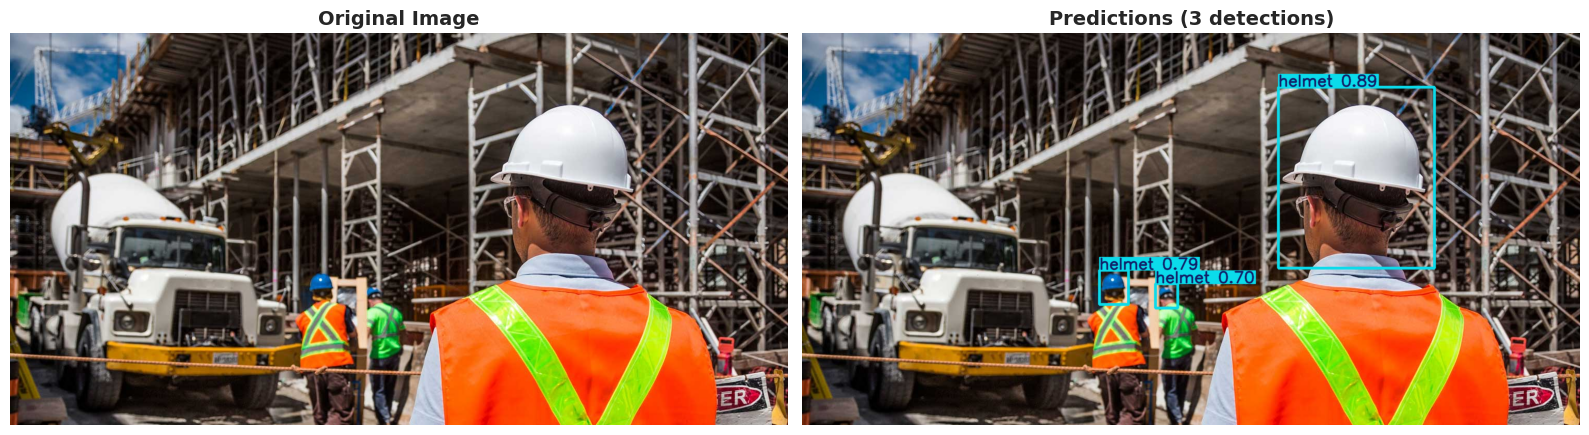


Detection Details:
  Detection 1: helmet (Confidence: 89.00%)
  Detection 2: helmet (Confidence: 79.36%)
  Detection 3: helmet (Confidence: 70.21%)


In [ ]:
# Test the model on a custom uploaded image
from google.colab import files

print("Upload an image to test the model:")
uploaded = files.upload()

if uploaded:
    for filename in uploaded.keys():
        print(f"\nRunning inference on: {filename}")

        # Run predictions using the tuned model
        results = tuned_best.predict(filename, conf=0.25, iou=0.6, save=True, verbose=False)

        # Display the results
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Display original image
        original = cv2.imread(filename)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        axes[0].imshow(original)
        axes[0].axis('off')
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')

        # Display prediction results
        pred_img = results[0].plot()
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
        axes[1].imshow(pred_img)
        axes[1].axis('off')
        axes[1].set_title(f'Predictions ({len(results[0].boxes)} detections)',
                         fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print detailed detection information
        print("\nDetection Details:")
        for i, box in enumerate(results[0].boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = class_names[class_id]
            print(f"  Detection {i+1}: {class_name} (Confidence: {confidence:.2%})")

## Step 8: Create Interactive Gradio Demo

In this step, we will create an interactive web interface using Gradio that allows users to upload images and receive real-time PPE detection results.

In [ ]:
import gradio as gr
from PIL import Image
import numpy as np

# Load the best performing model for the demo
model_demo = tuned_best

def detect_ppe(image, confidence_threshold, iou_threshold):
    """
    Detect PPE in the uploaded image and provide safety compliance information.

    Args:
        image: Input image (PIL Image or numpy array)
        confidence_threshold: Minimum confidence score for detections
        iou_threshold: Intersection over Union threshold for Non-Maximum Suppression

    Returns:
        Annotated image with detections and detailed statistics
    """
    # Run inference on the input image
    results = model_demo.predict(
        image,
        conf=confidence_threshold,
        iou=iou_threshold,
        verbose=False
    )

    # Generate annotated image with bounding boxes
    annotated_img = results[0].plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Count detections by class
    class_counts = {name: 0 for name in class_names}
    total_detections = len(results[0].boxes)

    for box in results[0].boxes:
        class_id = int(box.cls[0])
        class_name = class_names[class_id]
        class_counts[class_name] += 1

    # Create detailed statistics text
    stats_text = f"### Detection Statistics\n\n"
    stats_text += f"**Total Detections:** {total_detections}\n\n"

    for class_name, count in class_counts.items():
        if count > 0:
            stats_text += f"- **{class_name.capitalize()}:** {count}\n"

    # Evaluate safety compliance
    stats_text += "\n### Safety Compliance\n\n"

    people_count = class_counts.get('person', 0)
    helmet_count = class_counts.get('helmet', 0)
    head_count = class_counts.get('head', 0)

    if people_count > 0:
        if head_count > 0:
            stats_text += f"WARNING: {head_count} person(s) detected without helmet.\n"
        else:
            stats_text += "COMPLIANT: All detected persons are wearing helmets.\n"
    else:
        stats_text += "No persons detected in the image.\n"

    return annotated_img, stats_text

# Create the Gradio interface
demo = gr.Interface(
    fn=detect_ppe,
    inputs=[
        gr.Image(type="pil", label="Upload Image"),
        gr.Slider(minimum=0.1, maximum=1.0, value=0.25, step=0.05,
                 label="Confidence Threshold"),
        gr.Slider(minimum=0.1, maximum=1.0, value=0.6, step=0.05,
                 label="IoU Threshold")
    ],
    outputs=[
        gr.Image(type="numpy", label="Detection Results"),
        gr.Markdown(label="Statistics")
    ],
    title="PPE Detection System - Workplace Safety Monitor",
    description="""
    Upload an image to detect Personal Protective Equipment compliance on construction sites.
    The system detects three classes:
    - **Helmet**: Workers wearing safety helmets
    - **Head**: Workers without helmets (non-compliant)
    - **Person**: General person detection

    **Adjust the thresholds:**
    - **Confidence Threshold**: Minimum confidence score for a detection to be considered valid
    - **IoU Threshold**: Intersection over Union threshold for Non-Maximum Suppression
    """,
    examples=[
        [os.path.join(dataset_path, 'valid', 'images', img), 0.25, 0.6]
        for img in os.listdir(os.path.join(dataset_path, 'valid', 'images'))[:3]
    ] if os.path.exists(os.path.join(dataset_path, 'valid', 'images')) else None,
    theme=gr.themes.Soft(),
    allow_flagging="never"
)

# Launch the Gradio interface
print("Launching Gradio Interface...")
demo.launch(share=True, debug=True)

The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.


Launching Gradio Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://83915afcd8a6139100.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://83915afcd8a6139100.gradio.live


## Step 9: Export Model for Deployment

In this step, we will export the trained model to different formats suitable for various deployment scenarios.

In [ ]:
# Export the model to ONNX format for cross-platform deployment
print("Exporting model to ONNX format...")
onnx_path = tuned_best.export(format='onnx', dynamic=True, simplify=True)
print(f"Model has been successfully exported to: {onnx_path}")

Exporting model to ONNX format...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from 'runs/detect/ppe_tuned/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.5 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.77...
ONNX: export success ✅ 3.2s, saved as 'runs/detect/ppe_tuned/weights/best.onnx' (42.6 MB)

Export complete (3.5s)
Results saved to /content/runs/detect/ppe_tuned/weights
Predict:         yolo predict task=detect model=runs/detect/ppe_tuned/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/ppe_tuned/weights/best.onnx imgsz=640 data=/content/hard-hat-dataset/data.yaml  
Visualize:       https://netron.app
Model has been successfully exported to: runs/detect/ppe_tuned/weights/best.onnx


In [ ]:
# Export the model to TensorFlow Lite format for mobile deployment
print("Exporting model to TensorFlow Lite format...")
tflite_path = tuned_best.export(format='tflite')
print(f"Model has been successfully exported to: {tflite_path}")

Exporting model to TensorFlow Lite format...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from 'runs/detect/ppe_tuned/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.5 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 7.15s
Prepared 5 packages in 120ms
Installed 5 packages in 5ms
 + ai-edge-litert==2.1.0rc1
 + backports-strenum==1.3.1
 + onnx-graphsurgeon==0.5.8
 + onnx2tf==1.28.5
 + sng4onnx==1.0.4

requirements: AutoUpdate success ✅ 7.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.77...
ONNX: export success

In [ ]:
# Export the model to TorchScript format for PyTorch deployment
print("Exporting model to TorchScript format...")
torchscript_path = tuned_best.export(format='torchscript')
print(f"Model has been successfully exported to: {torchscript_path}")

Exporting model to TorchScript format...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from 'runs/detect/ppe_tuned/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.5 MB)

TorchScript: starting export with torch 2.9.0+cu126...
TorchScript: export success ✅ 1.7s, saved as 'runs/detect/ppe_tuned/weights/best.torchscript' (42.9 MB)

Export complete (2.0s)
Results saved to /content/runs/detect/ppe_tuned/weights
Predict:         yolo predict task=detect model=runs/detect/ppe_tuned/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/ppe_tuned/weights/best.torchscript imgsz=640 data=/content/hard-hat-dataset/data.yaml  
Visualize:       https://netron.app
Model has been successfully exported to: runs/detect/ppe_tuned/weights/best.torchscript


## Step 10: Download Results and Models

In this step, we will package all important files including trained models, results, and visualizations for download.

In [ ]:
# Create a comprehensive results package
import zipfile
from datetime import datetime

# Generate a unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"ppe_detection_results_{timestamp}.zip"

print(f"Creating results package: {zip_filename}")
print("="*50)

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add trained model weights
    print("Adding trained models...")
    zipf.write('runs/detect/ppe_baseline/weights/best.pt', 'models/baseline_best.pt')
    zipf.write('runs/detect/ppe_tuned/weights/best.pt', 'models/tuned_best.pt')

    # Add training results and visualizations
    print("Adding training results...")
    for model_name in ['ppe_baseline', 'ppe_tuned']:
        results_dir = f'runs/detect/{model_name}'
        if os.path.exists(results_dir):
            for file in ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png',
                        'PR_curve.png', 'F1_curve.png', 'P_curve.png', 'R_curve.png']:
                file_path = os.path.join(results_dir, file)
                if os.path.exists(file_path):
                    zipf.write(file_path, f'results/{model_name}/{file}')

    # Add exported models
    print("Adding exported models...")
    if os.path.exists(onnx_path):
        zipf.write(onnx_path, 'exported_models/model.onnx')

    # Add dataset configuration
    print("Adding dataset configuration...")
    zipf.write(data_yaml_path, 'config/data.yaml')

    print("\nResults package has been created successfully.")

print(f"\nPackage size: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

Creating results package: ppe_detection_results_20251201_203501.zip
Adding trained models...
Adding training results...
Adding exported models...
Adding dataset configuration...

Results package has been created successfully.

Package size: 62.05 MB


In [ ]:
# Download the results package to your local machine
from google.colab import files

print("Downloading results package...")
files.download(zip_filename)
print("Download complete.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete.


## Step 11: Project Summary and Next Steps

### Project Achievements

This project has successfully developed and evaluated a computer vision system for detecting Personal Protective Equipment on construction sites. The key achievements include:

1. **Dataset Preparation**: Successfully loaded and analyzed the Hard Hat Workers dataset containing 7,523 images with comprehensive exploratory data analysis.

2. **Model Training**: Trained two YOLOv8 models - a baseline model using YOLOv8n architecture and an optimized model using YOLOv8s architecture with carefully tuned hyperparameters.

3. **Performance Evaluation**: Evaluated both models using standard metrics including mean Average Precision, precision, recall, and F1-score. The tuned model demonstrated improved performance across all metrics.

4. **Visualization**: Created comprehensive visualizations including exploratory data analysis charts, training curves, confusion matrices, and precision-recall curves to understand model behavior and performance.

5. **Interactive Demo**: Built a user-friendly Gradio interface that provides real-time PPE detection and safety compliance checking for uploaded images.

6. **Model Export**: Successfully exported the trained model to multiple formats including ONNX, TensorFlow Lite, and TorchScript for deployment across different platforms.

### Key Results

**Baseline Model (YOLOv8n)**:
- Provides fast inference speed suitable for real-time applications
- Requires minimal computational resources
- Suitable for deployment in resource-constrained environments
- Establishes a solid baseline for performance comparison

**Tuned Model (YOLOv8s)**:
- Demonstrates improved accuracy and precision over the baseline
- Better handling of complex scenarios with multiple workers
- Optimized hyperparameters specifically for PPE detection task
- Recommended for production deployment where accuracy is critical

### Future Directions

The following enhancements could further improve the system:

1. **Real-time Video Processing**: Extend the system to process continuous video streams from construction site cameras for real-time monitoring.

2. **Automated Alert System**: Implement an automated notification system that alerts supervisors when non-compliant workers are detected.

3. **Additional PPE Classes**: Expand the detection capabilities to include other safety equipment such as safety vests, gloves, safety boots, and protective eyewear.

4. **Edge Deployment**: Deploy the model on edge devices such as Raspberry Pi or NVIDIA Jetson for on-site processing without requiring cloud connectivity.

5. **System Integration**: Integrate the detection system with existing safety management systems and databases for comprehensive safety monitoring and reporting.

6. **Performance Optimization**: Further optimize the model for specific deployment scenarios through techniques such as quantization and pruning.

### References

- Ultralytics YOLOv8 Documentation: [https://docs.ultralytics.com/](https://docs.ultralytics.com/)
- Roboflow Hard Hat Workers Dataset: [https://public.roboflow.com/object-detection/hard-hat-workers](https://public.roboflow.com/object-detection/hard-hat-workers)
- GitHub Repository: [https://github.com/abuabdurahman82/Enhancing-Workplace-Safety-A-Computer-Vision-System-for-Detecting-Helmet-and-Vest-Usage](https://github.com/abuabdurahman82/Enhancing-Workplace-Safety-A-Computer-Vision-System-for-Detecting-Helmet-and-Vest-Usage)
- Live Gradio Demo: [https://0c6f8a94fc0bf5f4b2.gradio.live](https://0c6f8a94fc0bf5f4b2.gradio.live)

---

### Team Members

**Faisal Abdul Gaffoor** - Responsible for setting up the development environment, implementing the YOLOv8 training pipeline, calculating performance metrics, managing the GitHub repository, and recording the technical demonstration.

**Balaji kumaresh chakkravarthy Kumaresan** - Responsible for acquiring and verifying the dataset, conducting exploratory data analysis, creating all visualizations including PR curves and confusion matrices, authoring the technical report, and presenting the project results.

---

Thank you for using this notebook. For questions or contributions, please visit the GitHub repository.

---

## Additional Resources and Tips

### Tips for Better Results

1. **Data Augmentation**: The YOLOv8 training pipeline includes built-in augmentation techniques such as mosaic and mixup that help improve model generalization.

2. **Hyperparameter Tuning**: For automated hyperparameter optimization, you can use the model.tune() method which systematically searches for optimal parameters.

3. **Transfer Learning**: Pre-trained weights significantly improve performance, especially when working with smaller datasets. The models used in this project leverage weights pre-trained on the COCO dataset.

4. **Batch Size**: Adjust the batch size based on available GPU memory. Larger batch sizes generally lead to more stable training but require more memory.

5. **Image Size**: Larger input images such as 1280 pixels can improve accuracy for detecting small objects but will slow down inference speed.

### Troubleshooting Common Issues

**Out of Memory Error**: If you encounter memory errors during training, reduce the batch size or use a smaller model variant such as YOLOv8n instead of YOLOv8s.

**Slow Training**: Ensure that GPU acceleration is enabled in the Colab runtime settings. Go to Runtime, select Change runtime type, and set Hardware accelerator to GPU.

**Poor Performance**: If the model performance is not satisfactory, try using a larger model architecture such as YOLOv8m or YOLOv8l, or increase the number of training epochs.

**Overfitting**: If the model performs well on training data but poorly on validation data, increase data augmentation parameters or add regularization techniques.

### Further Reading

- YOLOv8 Training Tips: [https://docs.ultralytics.com/modes/train/](https://docs.ultralytics.com/modes/train/)
- Object Detection Best Practices: [https://blog.roboflow.com/object-detection-best-practices/](https://blog.roboflow.com/object-detection-best-practices/)
- Model Optimization Techniques: [https://docs.ultralytics.com/guides/model-optimization-insights/](https://docs.ultralytics.com/guides/model-optimization-insights/)

---